In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)

# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('popular')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt
from sklearn.metrics import plot_precision_recall_curve

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/olegzartdinov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/olegzartdinov/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/olegzartdinov/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/olegzartdinov/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/olegzartdinov/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/olegzartdinov/nltk_data...
[nltk_data]    |   Package inaugural

**Пути к директориям и папкам**

In [2]:
TRAIN_DATASET_PATH = 'HeadHunter_train.csv'
TEST_DATASET_PATH = 'HeadHunter_test.csv'

# Загрузка данных

**Описание датасета**

В датасете представлены отзывы на разных работодателей с разными характеристиками

**Задача:**

Участникам предстоит предсказать причины (закодированы числами от 1 до 8 ) по которым отзыв не проходит модерацию. Причин, по которым отзыв не прошёл модерацию может быть несколько. Если отзыв проходит модерацию, то вместо причины отказа нужно отправлять 0. Значение 0 разрешается комбинировать с причинами отказа. 

# Предварительный анализ
**Для начала посмотрим на данные**

In [3]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, index_col = 'review_id')
train_df.head()

,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating,target
review_id,,,,,,,,,,,
0,Ижевск,Кладовщик,"Недавно устроился в ****** на должность кладовщика. Коллектив дружный и приветливый к новичкам - во всем помогают и поддерживают. Зарплата вся белая и без задержек, что сейчас редкость. Всем доволен и рекомендую данного работодателя.",Повысить з/п,5,4,3,3,4,4,0
1,Москва,Руководитель проекта,"Расположение офиса, своего рода стабильность (госбанк)","Упростить процессы - все процессы ради процессов, а не результата. Избавиться от чрезмерного уровня бюрократии. Внедрить нормальный электронный документооборот - сейчас все на бумажках, даже то, что заводится в ЭДО. Высшему руководству избавиться от нежелания видеть проблемы - сейчас действует принцип «не вижу проблемы, значит ее нет».",4,4,4,1,1,1,8
2,Екатеринбург,Консультант,"В нашем банке все по закону в плане зарплаты и графика. Никаких переработок и прочего. Для меня второе очень важно потому что у меня дети , с ними тоже надо проводить время, а если я буду до 12 засиживаться в офисе, то не знаю как и управиться с ними) Короче, работой в этом банке я довольна",Ничего,5,5,5,5,5,5,0
5,Санкт-Петербург,Оператор,"Я в ****** около года работаю оператором. Нормальная работа, коллектив у нас дружный. Начальство понимающее. А самое главное, что как обещали на собеседовании, так и платят. Все честно. Я доволен.",Нет.,5,5,5,5,5,5,0
7,Москва,Инженер КИПиА,В принципе норм.Работать можно,Всегда есть к чему стремиться,4,5,4,2,5,2,8


In [4]:
test_df = pd.read_csv(TEST_DATASET_PATH, index_col = 'review_id')
test_df.head()

,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating
review_id,,,,,,,,,,
3,Москва,Старший специалист,"Свобода в выборе рабочего графика, условия труда",****** всегда стремится к улучшению всего,5,5,5,5,5,5
4,Москва,Менеджер по персоналу,Компания делает ставки на молодых и перспективных,"Слабая оснащённость рабочих мест, отсутствие ДМС, слабая корпоративная жизнь",4,5,4,5,4,4
13,Тверь,Тренинг-менеджер,Есть возможность для развития,Увеличить уровень дохода,2,5,5,5,5,5
14,Уфа,Специалист отдела кадров,"Хороший коллектив, размереная работа, нет переработки, комфортные условия труда.","Обучение сотрудников, ротацию кадров, увеличение зарплаты.",2,5,5,2,4,4
17,Москва,Бизнес-аналитик,"Гибкость в рабочем графике, коллектив.",Уровень представленности HR-бренда.,5,5,5,5,5,5


In [5]:
train_df.shape, test_df.shape

((50876, 11), (50651, 10))

**Приведение типов**

In [6]:
train_df.dtypes

city                    object
position                object
positive                object
negative                object
salary_rating            int64
team_rating              int64
managment_rating         int64
career_rating            int64
workplace_rating         int64
rest_recovery_rating     int64
target                  object
dtype: object

# Обзор данных
**Целевая переменная (target)**

**Посмотрим на распределение целевой переменной в train, возможно что одобренных отзывов в датасете сильно больше, тогда придется что-то делать с несбалансированностью**

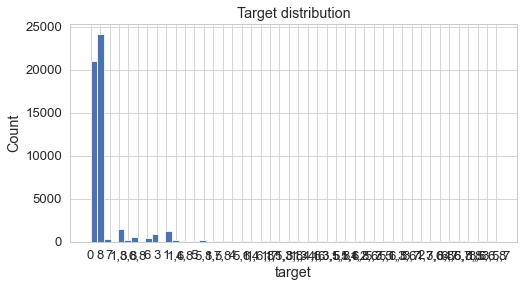

In [7]:
#построим график распределения целевой переменной
plt.figure(figsize = (8,4))

train_df['target'].hist(bins=60)
plt.ylabel('Count')
plt.xlabel('target')
plt.title('Target distribution');

Построим более наглядный countplot

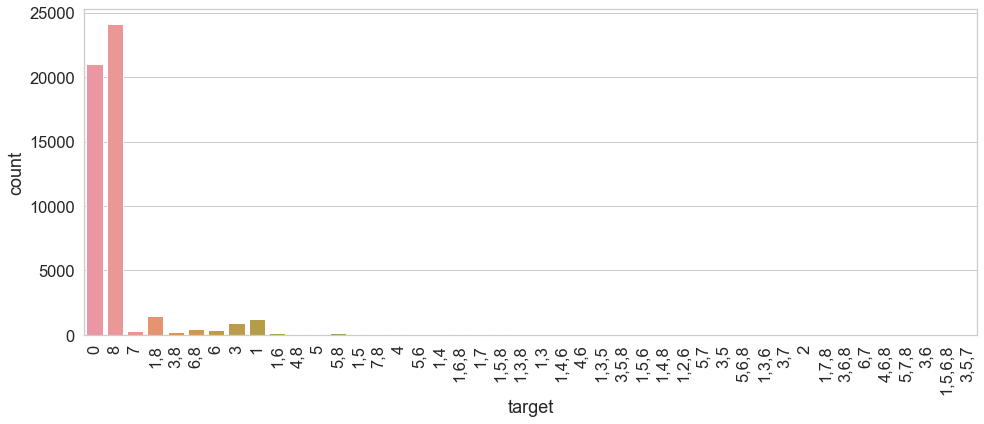

In [8]:
#посмотрим распределение на графике
sns.set(style="whitegrid", font_scale=1.5)
f, ax = plt.subplots(figsize=(16,6))
sns.countplot(x='target', data=train_df);
ax.tick_params(axis='x', rotation=90)
ax.xaxis.set_major_locator(plt.MaxNLocator(50))

Несмотря на то, что правильно график построить не удалось видно, что лидирует причина номер 8

Посмотрим на значения, чтобы определить в чем причина

In [9]:
train_df['target'].value_counts()

8          24093
0          21003
1,8         1476
1           1269
3            905
6,8          473
6            368
7            326
3,8          209
1,6          141
5,8          121
5            102
1,5           78
1,6,8         48
4             38
4,8           36
1,5,8         33
7,8           25
1,4           24
1,7           15
5,7           13
2             12
5,6            9
1,3            9
1,5,6          7
5,6,8          6
3,7            5
4,6            5
1,4,8          4
1,3,8          3
1,4,6          3
6,7            3
1,7,8          2
1,3,5          2
3,5,8          1
5,7,8          1
3,6            1
1,3,6          1
3,5,7          1
1,2,6          1
1,5,6,8        1
3,6,8          1
4,6,8          1
3,5            1
Name: target, dtype: int64

Ответ найден, один отзыв может иметь более одной причины отказа, поэтому они перечислены через запятую. Постараемся исправить ситуацию в дальнейшем.

# Первые выводы

Датасет train вполне сбалансирован, 21003 отзыва (из 50876) проходят модерацию. Из оставшихся 29873 отзывов большая часть имеет единственную причину отказа номер 8 (24093 отзыва), оставшиеся отзывы (5780) имеют другие или несколько причин отказа. 

In [10]:
#посмотрим на количество уникальных значений признаков
train_df.nunique()

city                      852
position                12258
positive                46988
negative                45029
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               6
workplace_rating            5
rest_recovery_rating        5
target                     44
dtype: int64

В нескольких признаках всего несколько значений, поэтому их можно будет отнести к категориальным (salary_rating, team_rating, managment_rating, career_rating, workplace_rating, rest_recovery_rating). Очевидно, что рейтинг выставлялся в звёздах от 1 до 5.

**Career_rating**

In [11]:
#рассмотрим значения в перспективах карьеры
train_df['career_rating'].value_counts()

5    18820
1    10436
4     8398
3     7752
2     5444
0       26
Name: career_rating, dtype: int64

Несмотря на большое желание произвести замену, оценка 0 может быть как пропущенным значением автоматически заполненным, так и крайней степенью раздражения и соответственно сильно коррелировать с негативным отзывов не прошедшим проверку

In [12]:
#проверим эту теорию
train_df[train_df['career_rating'] == 0].head()

,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating,target
review_id,,,,,,,,,,,
1808,Воронеж,NaN,"Многие пугаются той ответственности и многозадачности, при которых нам приходится работать в компании. Некоторые сотрудники просто не выдерживают нагрузки, на мой взгляд, сложности для того и существуют, чтобы с ними справляться. Мне, как новичку, тоже было тяжело первое время. Но у меня была цель достигнуть хороших результатов, учила всю информацию, которую мне предоставляли и которую сама находила в интернете, спрашивала советов у своих более опытных коллег. Не могу сказать, что прям все бросали свои дела и сидели со мной, но совет дать могли, дружеская атмосфера присутствует, поэтому приятно работать в компании. Хоть коллектив большой, можно найти своих единомышленников. Благо, что еще начальство нормальное, видят разницу между опытным сотрудником и новичком, который только только вчера пришел в компанию. Невыполнимых задач не ставит перед сотрудниками, так что все приходит с опытом. То, что в ****** берут без опыта - плюс. Много внимания уделяют обучению своих сотрудников: семинары, тренинги, в общем есть возможность профессионального развития.","Люди, которые здесь работают давно, неплохо зарабатывают. Так что есть к чему стремиться.",5,5,5,0,3,3,0
6247,Киев,NaN,"Вот только закончила стажировку, переводят уже в полноценные сотрудники компании. Работа в офисе интересная, мне нравится, да и условия, считаю, отличные. Требуют, конечно, много, но я надеюсь втянусь и все освою. Уже подругами обзавелась, коллектив здесь дружный. Очень хочу задержаться здесь надолго.",все устраивает,5,5,3,0,5,3,0
10970,Москва,NaN,"Плюсов У ****** как у работодателя много. Во-первых оформление официальное, во-вторых выплаты без задержек, премии за хорошую работу даются раз в несколько месяцев, у каждого подразделения своя бонусная система. Вахтовикам бесплатное общежитие предоставляется и других ""плюшек"" много, смотря кем работать.","Не думал об этом, особенных замечаний у меня нет.",5,5,5,0,5,4,0
13030,Москва,Швея,"Очень нравится здесь работать. Очень хорошее отношения руководства к работникам несомненно радует. Достойная оплата труда, дружный коллектив.",Меня всё устраивает,5,5,5,0,5,4,0
15028,Москва,NaN,"Прекрасный коллектив, в котором действительно помогут и все объяснят по столько раз, сколько потребуется. Начальство идёт навстречу и относится с пониманием к косякам.",Маленькое количество инструкторов = не обучают на многие позиции.,3,5,5,0,5,3,0


Теория не оправдалась, поэтому заменим все значния 0 на среднее-арифметическое от оценок salary_rating, team_rating, managment_rating, workplace_rating, rest_recovery_rating

In [13]:
#произведём замену
train_df.loc[train_df['career_rating'] == 0, 'career_rating'] = round((train_df['salary_rating']+train_df['team_rating']+train_df['managment_rating']+train_df['workplace_rating']+train_df['rest_recovery_rating'])/5)
test_df.loc[test_df['career_rating'] == 0, 'career_rating'] = round((test_df['salary_rating']+test_df['team_rating']+test_df['managment_rating']+test_df['workplace_rating']+test_df['rest_recovery_rating'])/5) 

In [14]:
#проверим результат в train
train_df['career_rating'].value_counts()

5.00    18833
1.00    10436
4.00     8409
3.00     7754
2.00     5444
Name: career_rating, dtype: int64

In [15]:
#проверим результат в test
test_df['career_rating'].value_counts()

5.00    17576
1.00    10642
3.00     8609
4.00     7950
2.00     5874
Name: career_rating, dtype: int64

**Заменим все рейтинги на словесное описание**  
Ужасно  
Плохо  
Нормально  
Хорошо  
Отлично

**salary_rating**

In [16]:
train_df.loc[(train_df['salary_rating'] == 1), 'salary_rating'] = "ужасно"
train_df.loc[(train_df['salary_rating'] == 2), 'salary_rating'] = "плохо"
train_df.loc[(train_df['salary_rating'] == 3), 'salary_rating'] = "нормально"
train_df.loc[(train_df['salary_rating'] == 4), 'salary_rating'] = "хорошо"
train_df.loc[(train_df['salary_rating'] == 5), 'salary_rating'] = "отлично"

In [17]:
#проверим результат в train
train_df['salary_rating'].value_counts()

отлично      17893
хорошо        9739
нормально     8911
ужасно        8561
плохо         5772
Name: salary_rating, dtype: int64

In [18]:
test_df.loc[(test_df['salary_rating'] == 1), 'salary_rating'] = "ужасно"
test_df.loc[(test_df['salary_rating'] == 2), 'salary_rating'] = "плохо"
test_df.loc[(test_df['salary_rating'] == 3), 'salary_rating'] = "нормально"
test_df.loc[(test_df['salary_rating'] == 4), 'salary_rating'] = "хорошо"
test_df.loc[(test_df['salary_rating'] == 5), 'salary_rating'] = "отлично"

In [19]:
#проверим результат в test
test_df['salary_rating'].value_counts()

отлично      15129
нормально    10520
хорошо        9798
ужасно        8809
плохо         6395
Name: salary_rating, dtype: int64

**team_rating**

In [20]:
train_df.loc[(train_df['team_rating'] == 1), 'team_rating'] = "ужасно"
train_df.loc[(train_df['team_rating'] == 2), 'team_rating'] = "плохо"
train_df.loc[(train_df['team_rating'] == 3), 'team_rating'] = "нормально"
train_df.loc[(train_df['team_rating'] == 4), 'team_rating'] = "хорошо"
train_df.loc[(train_df['team_rating'] == 5), 'team_rating'] = "отлично"

In [21]:
#проверим результат в train
train_df['team_rating'].value_counts()

отлично      30263
хорошо        8772
нормально     5059
ужасно        4286
плохо         2496
Name: team_rating, dtype: int64

In [22]:
test_df.loc[(test_df['team_rating'] == 1), 'team_rating'] = "ужасно"
test_df.loc[(test_df['team_rating'] == 2), 'team_rating'] = "плохо"
test_df.loc[(test_df['team_rating'] == 3), 'team_rating'] = "нормально"
test_df.loc[(test_df['team_rating'] == 4), 'team_rating'] = "хорошо"
test_df.loc[(test_df['team_rating'] == 5), 'team_rating'] = "отлично"

In [23]:
#проверим результат в test
test_df['team_rating'].value_counts()

отлично      29775
хорошо        8603
нормально     5440
ужасно        4282
плохо         2551
Name: team_rating, dtype: int64

**managment_rating**

In [24]:
train_df.loc[(train_df['managment_rating'] == 1), 'managment_rating'] = "ужасно"
train_df.loc[(train_df['managment_rating'] == 2), 'managment_rating'] = "плохо"
train_df.loc[(train_df['managment_rating'] == 3), 'managment_rating'] = "нормально"
train_df.loc[(train_df['managment_rating'] == 4), 'managment_rating'] = "хорошо"
train_df.loc[(train_df['managment_rating'] == 5), 'managment_rating'] = "отлично"

In [25]:
#проверим результат в train
train_df['managment_rating'].value_counts()

отлично      21812
ужасно       10706
хорошо        8450
нормально     5713
плохо         4195
Name: managment_rating, dtype: int64

In [26]:
test_df.loc[(test_df['managment_rating'] == 1), 'managment_rating'] = "ужасно"
test_df.loc[(test_df['managment_rating'] == 2), 'managment_rating'] = "плохо"
test_df.loc[(test_df['managment_rating'] == 3), 'managment_rating'] = "нормально"
test_df.loc[(test_df['managment_rating'] == 4), 'managment_rating'] = "хорошо"
test_df.loc[(test_df['managment_rating'] == 5), 'managment_rating'] = "отлично"

In [27]:
#проверим результат в test
test_df['managment_rating'].value_counts()

отлично      20941
ужасно       10647
хорошо        8066
нормально     6437
плохо         4560
Name: managment_rating, dtype: int64

**career_rating**

In [28]:
train_df.loc[(train_df['career_rating'] == 1), 'career_rating'] = "ужасно"
train_df.loc[(train_df['career_rating'] == 2), 'career_rating'] = "плохо"
train_df.loc[(train_df['career_rating'] == 3), 'career_rating'] = "нормально"
train_df.loc[(train_df['career_rating'] == 4), 'career_rating'] = "хорошо"
train_df.loc[(train_df['career_rating'] == 5), 'career_rating'] = "отлично"

In [29]:
#проверим результат в train
train_df['career_rating'].value_counts()

отлично      18833
ужасно       10436
хорошо        8409
нормально     7754
плохо         5444
Name: career_rating, dtype: int64

In [30]:
test_df.loc[(test_df['career_rating'] == 1), 'career_rating'] = "ужасно"
test_df.loc[(test_df['career_rating'] == 2), 'career_rating'] = "плохо"
test_df.loc[(test_df['career_rating'] == 3), 'career_rating'] = "нормально"
test_df.loc[(test_df['career_rating'] == 4), 'career_rating'] = "хорошо"
test_df.loc[(test_df['career_rating'] == 5), 'career_rating'] = "отлично"

In [31]:
#проверим результат в test
test_df['career_rating'].value_counts()

отлично      17576
ужасно       10642
нормально     8609
хорошо        7950
плохо         5874
Name: career_rating, dtype: int64

**workplace_rating**

In [32]:
train_df.loc[(train_df['workplace_rating'] == 1), 'workplace_rating'] = "ужасно"
train_df.loc[(train_df['workplace_rating'] == 2), 'workplace_rating'] = "плохо"
train_df.loc[(train_df['workplace_rating'] == 3), 'workplace_rating'] = "нормально"
train_df.loc[(train_df['workplace_rating'] == 4), 'workplace_rating'] = "хорошо"
train_df.loc[(train_df['workplace_rating'] == 5), 'workplace_rating'] = "отлично"

In [33]:
#проверим результат в train
train_df['workplace_rating'].value_counts()

отлично      23073
хорошо        9537
ужасно        7286
нормально     6908
плохо         4072
Name: workplace_rating, dtype: int64

In [34]:
test_df.loc[(test_df['workplace_rating'] == 1), 'workplace_rating'] = "ужасно"
test_df.loc[(test_df['workplace_rating'] == 2), 'workplace_rating'] = "плохо"
test_df.loc[(test_df['workplace_rating'] == 3), 'workplace_rating'] = "нормально"
test_df.loc[(test_df['workplace_rating'] == 4), 'workplace_rating'] = "хорошо"
test_df.loc[(test_df['workplace_rating'] == 5), 'workplace_rating'] = "отлично"

In [35]:
#проверим результат в test
test_df['workplace_rating'].value_counts()

отлично      22568
хорошо        9192
нормально     7362
ужасно        7300
плохо         4229
Name: workplace_rating, dtype: int64

**rest_recovery_rating**

In [36]:
train_df.loc[(train_df['rest_recovery_rating'] == 1), 'rest_recovery_rating'] = "ужасно"
train_df.loc[(train_df['rest_recovery_rating'] == 2), 'rest_recovery_rating'] = "плохо"
train_df.loc[(train_df['rest_recovery_rating'] == 3), 'rest_recovery_rating'] = "нормально"
train_df.loc[(train_df['rest_recovery_rating'] == 4), 'rest_recovery_rating'] = "хорошо"
train_df.loc[(train_df['rest_recovery_rating'] == 5), 'rest_recovery_rating'] = "отлично"

In [37]:
#проверим результат в train
train_df['rest_recovery_rating'].value_counts()

отлично      20305
ужасно       11714
хорошо        8243
нормально     6037
плохо         4577
Name: rest_recovery_rating, dtype: int64

In [38]:
test_df.loc[(test_df['rest_recovery_rating'] == 1), 'rest_recovery_rating'] = "ужасно"
test_df.loc[(test_df['rest_recovery_rating'] == 2), 'rest_recovery_rating'] = "плохо"
test_df.loc[(test_df['rest_recovery_rating'] == 3), 'rest_recovery_rating'] = "нормально"
test_df.loc[(test_df['rest_recovery_rating'] == 4), 'rest_recovery_rating'] = "хорошо"
test_df.loc[(test_df['rest_recovery_rating'] == 5), 'rest_recovery_rating'] = "отлично"

In [39]:
#проверим результат в test
test_df['rest_recovery_rating'].value_counts()

отлично      18706
ужасно       12137
хорошо        7402
нормально     7163
плохо         5243
Name: rest_recovery_rating, dtype: int64

# Обработка пропущенных значений

In [40]:
#посмотрим на пропущенные значения
train_df.isna().sum()[train_df.isna().sum() != 0]

city        3351
position    4658
positive      39
negative     137
dtype: int64

Пропущенне значения есть в четырех категориях (city, position, positive, negative)

**Обработка категории city**

In [41]:
#посмотрим на количество разных городов
print(train_df['city'].nunique(), 'уникальных значений в train')
print(test_df['city'].nunique(), 'уникальных значений в train')

852 уникальных значений в train
815 уникальных значений в train


In [42]:
#выведем список наиболее популярных городов
#city_count = train_df['city'].value_counts().reset_index().rename(columns={'index': 'city', 'city':'citycount'})
#city_count

In [43]:
#посмотрим на города, где больше 200 отзывов
#city_count.loc[city_count['citycount'] > 200, :]

Получилось 22 города с отзывами более 200

In [44]:
#внесём все популярные районы в список
#city_popular = city_count.loc[city_count['citycount'] > 200, 'city'].tolist()
#city_popular

In [45]:
#произведём замену
#city_count.loc[~city_count['city'].isin(city_popular), 'city'] = "Другой"
#city_count = city_count.groupby('city')['citycount'].agg(citycount='median')
#city_count.reset_index(level='city', inplace=True)

In [46]:
#проверим результат
#city_count

In [47]:
#заменим в train и test
#train_df.loc[~train_df['city'].isin(city_popular), 'city'] = "Другой"
#test_df.loc[~test_df['city'].isin(city_popular), 'city'] = "Другой"

In [48]:
#проверим результат в test
#test_df['city'].value_counts()

In [49]:
#заменим пропущенные профессии пробелами
train_df.loc[train_df['city'].isna(), 'city'] = " "
test_df.loc[test_df['city'].isna(), 'city'] = " "

In [50]:
#посмотрим на количество разных позиций
print(train_df['city'].nunique(), 'уникальных значений в train')
print(test_df['city'].nunique(), 'уникальных значений в train')

853 уникальных значений в train
816 уникальных значений в train


<span style="color:red">Хороший признак, только около 25% городов входят в категорию Другой</span>

**Обработка категории position**

In [51]:
#посмотрим на количество разных позиций
print(train_df['position'].nunique(), 'уникальных значений в train')
print(test_df['position'].nunique(), 'уникальных значений в train')

12258 уникальных значений в train
13274 уникальных значений в train


In [52]:
#выведем список наиболее популярных позиций
#position_count = train_df['position'].value_counts().reset_index().rename(columns={'index': 'position', 'position':'positioncount'})
#position_count

In [53]:
#посмотрим на позиции, где больше 300 отзывов
#position_count.loc[position_count['positioncount'] > 200, :]

Получилось 27 профессий с отзывами более 200

In [54]:
#внесём все популярные позиции в список
#position_popular = position_count.loc[position_count['positioncount'] > 200, 'position'].tolist()
#position_popular

In [55]:
#произведём замену
#position_count.loc[~position_count['position'].isin(position_popular), 'position'] = "Другой"
#position_count = position_count.groupby('position')['positioncount'].agg(positioncount='median')
#position_count.reset_index(level='position', inplace=True)

In [56]:
#проверим результат
#position_count

In [57]:
#заменим в train и test
#train_df.loc[~train_df['position'].isin(position_popular), 'position'] = "Другая"
#test_df.loc[~test_df['position'].isin(position_popular), 'position'] = "Другая"

In [58]:
#проверим результат в test
#test_df['position'].value_counts()

In [59]:
#заменим пропущенные профессии пробелами
train_df.loc[train_df['position'].isna(), 'position'] = " "
test_df.loc[test_df['position'].isna(), 'position'] = " "

In [60]:
#посмотрим на количество разных позиций
print(train_df['position'].nunique(), 'уникальных значений в train')
print(test_df['position'].nunique(), 'уникальных значений в train')

12259 уникальных значений в train
13275 уникальных значений в train


<span style="color:red">В отличие от списка городов, где всего 25% городов входят в категорию Другой, в списке профессий почти 80% профессий не входят в список популярных. Скорее всего признак придётся удалить</span>

**Обработка категории positive**

In [61]:
#посмотрим повлияло ли отсутсвие положительного части отзыва на модерацию отзыва
bool_series_positive = pd.isnull(train_df["positive"])
train_df[bool_series_positive].head()

,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating,target
review_id,,,,,,,,,,,
18733,Истра,Кассир-консультант,NaN,NaN,хорошо,отлично,нормально,нормально,нормально,хорошо,8
32105,Москва,Водитель-экспедитор,NaN,NaN,ужасно,нормально,ужасно,ужасно,ужасно,ужасно,8
37600,Екатеринбург,Кладовщик,NaN,NaN,плохо,нормально,ужасно,ужасно,ужасно,ужасно,8
37689,Белгород,Кладовщик,NaN,NaN,ужасно,отлично,ужасно,плохо,ужасно,хорошо,8
39717,Москва,,NaN,NaN,ужасно,ужасно,ужасно,ужасно,ужасно,ужасно,8


In [62]:
#заменим пропущенные отзывы пробелами
train_df.loc[train_df['positive'].isna(), 'positive'] = " "
test_df.loc[test_df['positive'].isna(), 'positive'] = " "

<span style="color:red">В 100% случаев отсутсвие положительной части отзыва приводит к отсутствии и негативного отзыва и причине отказа номер 8</span>

**Обработка категории negative**

In [63]:
#посмотрим повлияло ли отсутсвие негативной части отзыва на модерацию отзыва
bool_series_negative = pd.isnull(train_df['negative'])
train_df[bool_series_negative].head()

,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating,target
review_id,,,,,,,,,,,
3047,,Продавец,"Почитать отзывы, так одни абсолютно за, а другие категорически против. Люди! Вы о чем? Если поставили цель - работайте. В каждом коллективе есть разные сотрудники. Но если относиться по человечески, и с вами будут нормально работать. Остается только выполнять свою работу и зарабатывать деньги.",NaN,отлично,отлично,хорошо,хорошо,отлично,отлично,0
8042,Москва,,Работа не сложная и довольно интересная. Директора компитентные и если что всегда готовы помочь. З/п и премии тоже приятные. Сама работаю уже 3-ий год и все устраивает.,NaN,отлично,отлично,отлично,отлично,отлично,отлично,0
8333,Воронеж,,"Ребята, в ****** нормально к людям относятся. Компенсируют расходы на ГСМ, амортизацию авто, проживание, суточные когда в командировку ездишь. А они очень часто бывают. Раньше работал в другой компании тоже региональным менеджером и тоже были командировки, так там все за счет процентов от продаж было. Никто ничего не оплачивал.",NaN,отлично,отлично,отлично,отлично,отлично,отлично,0
9985,Москва,,"Когда-то еще студентом работал тут. Тогда мне казалось эта работа вполне приемлемой. Удобный график, возможность заработать неплохие деньги. Тогда был молодой коллектив. Мы часто соревновались с друг другом, кто быстрее добьется поставленных результатов. Это подстегивало))",NaN,отлично,отлично,отлично,отлично,отлично,отлично,0
12624,Москва,,"В компании есть возможность самостоятельно влиять на свою заработную плату, Тут я получаю ценный опыт, который в дальнейшем очень пригодится, и прошу заметить, не только со стороны профессиональных качеств, но и личностных. Увольняться еще не собираюсь.",NaN,отлично,отлично,хорошо,отлично,хорошо,отлично,0


In [64]:
#заменим пропущенные отзывы пробелами
train_df.loc[train_df['negative'].isna(), 'negative'] = " "
test_df.loc[test_df['negative'].isna(), 'negative'] = " "

<span style="color:red">Отсутствие негативной части отзыва не приводит автоматически к причине 8, и оценка происходит на основе данных положительной части</span>

In [65]:
#посмотрим на пропущенные значения
train_df.isna().sum()[train_df.isna().sum() != 0]
test_df.isna().sum()[test_df.isna().sum() != 0]

Series([], dtype: int64)

<span style="color:red">Все пропущенные значения обработаны</span>

# Для лучшего понимания попробуем установить, что значат цифры в причинах отказа

In [66]:
#выведем 5 отзывов с причиной отказа 1
#train_df[train_df['target'] == '1'].head()

Причина номер 1 похоже соответствует причине **"Оскорбительные слова"**

In [67]:
#выведем 5 отзывов с причиной отказа 2
#train_df[train_df['target'] == '2'].head()

Причина номер 2 похоже соответствует причине **"Излишние размышления"**

In [68]:
#выведем 5 отзывов с причиной отказа 3
#train_df[train_df['target'] == '3'].head()

Причина номер 3 похоже соответствует причине **"Полнейшая белиберда"**

In [69]:
#выведем 5 отзывов с причиной отказа 4
#train_df[train_df['target'] == '4'].head()

Причина номер 4 похоже соответствует причине **"Наличие расистских высказываний"**

In [70]:
#выведем 5 отзывов с причиной отказа 5
#train_df[train_df['target'] == '5'].head()

Причина номер 5 похоже соответствует причине **"Упоминание имен"**

In [71]:
#выведем 5 отзывов с причиной отказа 6
#train_df[train_df['target'] == '6'].head()

Причина номер 6 похоже соответствует причине **"Упоминание зарплаты"**

In [72]:
#выведем 5 отзывов с причиной отказа 7
#train_df[train_df['target'] == '7'].sample(n = 5, random_state = 5)

Причина номер 7 похоже соответствует причине **"Непрошенные советы"**

In [73]:
#выведем 5 отзывов с причиной отказа 8
#train_df[train_df['target'] == '8'].head()

Причина номер 8 похоже соответствует причине **"Отсутствие смысла"**

Весь список причин отказов:  
**1) Оскорбительные слова**  
**2) Излишние размышления**  
**3) Полнейшая белиберда**  
**4) Наличие расистских высказываний**  
**5) Упоминание имен**  
**6) Упоминание зарплаты**  
**7) Непрошенные советы**  
**8) Отсутствие смысла**

# Для упрощения задачи для начала построим модель, определяющую бинарную классификацию отзыва (прошел/отказ) без указания конкретных причин

Для этого во-первых преобразуем данные по отзывам в 0 (отзыв прошел) и 1 (отзыв не прошел модерацию по одной из 8 причин)

In [74]:
#скопируем столбец target
train_df['target_review'] = train_df['target']

In [75]:
#проверим создание
train_df.head(1)

,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating,target,target_review
review_id,,,,,,,,,,,,
0,Ижевск,Кладовщик,"Недавно устроился в ****** на должность кладовщика. Коллектив дружный и приветливый к новичкам - во всем помогают и поддерживают. Зарплата вся белая и без задержек, что сейчас редкость. Всем доволен и рекомендую данного работодателя.",Повысить з/п,отлично,хорошо,нормально,нормально,хорошо,хорошо,0,0


In [76]:
#заменим все значения причин 1 - 8 на 1
train_df.loc[(train_df['target_review'] != "0"), 'target_review'] = 1
train_df.loc[(train_df['target_review'] != 1), 'target_review'] = 0

In [77]:
#проверим результат
train_df['target_review'].value_counts()

1    29873
0    21003
Name: target_review, dtype: int64

In [78]:
train_df.dtypes

city                    object
position                object
positive                object
negative                object
salary_rating           object
team_rating             object
managment_rating        object
career_rating           object
workplace_rating        object
rest_recovery_rating    object
target                  object
target_review           object
dtype: object

1    29873
0    21003
Name: target_review, dtype: int64


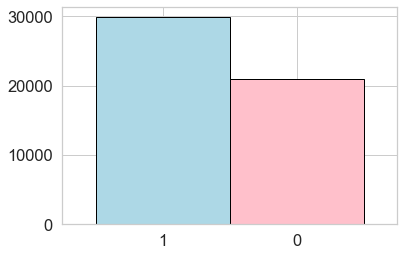

In [79]:
#построим график распределения целевой переменной target_review
print(train_df['target_review'].value_counts())
train_df['target_review'].value_counts().plot.bar(edgecolor='black', rot=0, width=1, color=['lightblue', 'pink']);

Классы получились сбалансированными

# Начнём обработку текстового отзыва

In [80]:
#объединим части негативного и позитивного отзывов, также добавим city, position и рейтинги
train_df['review_union'] = train_df['city'] + " " + train_df['position'] + " " + train_df['positive'] + " " + train_df['negative'] + " " + train_df['salary_rating'] + " " + train_df['team_rating'] + " " + train_df['managment_rating'] + " " + train_df['career_rating'] + " " + train_df['workplace_rating'] + " " + train_df['rest_recovery_rating']
test_df['review_union'] = test_df['city'] + " " + test_df['position'] + " " +test_df['positive'] + " " + test_df['negative']+ " " + test_df['salary_rating'] + " " + test_df['team_rating'] + " " + test_df['managment_rating'] + " " + test_df['career_rating'] + " " + test_df['workplace_rating'] + " " + test_df['rest_recovery_rating']

In [81]:
train_df['target_review'] = train_df['target_review'].apply(int)

In [82]:
train_df['target_review'].value_counts()

1    29873
0    21003
Name: target_review, dtype: int64

In [83]:
#разобьёем train_df на train и test
train_df_split, test_df_split = train_test_split(train_df, test_size=2000, random_state=0)

In [84]:
test_df_split.shape

(2000, 13)

In [85]:
test_df_split['target_review'].value_counts()

1    1186
0     814
Name: target_review, dtype: int64

In [86]:
train_df_split['target_review'].value_counts()

1    28687
0    20189
Name: target_review, dtype: int64

**Предобработка текста**

In [87]:
#разобьём предложения на токены
sentence_example = train_df.iloc[1]["review_union"]
tokens = word_tokenize(sentence_example, language="russian")
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation]
russian_stop_words = stopwords.words("russian")
tokens_without_stop_words_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words]
snowball = SnowballStemmer(language="russian")
stemmed_tokens = [snowball.stem(i) for i in tokens_without_stop_words_and_punctuation]

In [88]:
#проверим работоспособность
print(f"Исходный текст: {sentence_example}")
print("-----------------")
print(f"Токены: {tokens}")
print("-----------------")
print(f"Токены без пунктуации: {tokens_without_punctuation}")
print("-----------------")
print(f"Токены без пунктуации и стоп слов: {tokens_without_stop_words_and_punctuation}")
print("-----------------")
print(f"Токены после стемминга: {stemmed_tokens}")
print("-----------------")

Исходный текст: Москва Руководитель проекта Расположение офиса, своего рода стабильность (госбанк) Упростить процессы - все процессы ради процессов, а не результата. Избавиться от чрезмерного уровня бюрократии. Внедрить нормальный электронный документооборот - сейчас все на бумажках, даже то, что заводится в ЭДО. Высшему руководству избавиться от нежелания видеть проблемы - сейчас действует принцип «не вижу проблемы, значит ее нет». хорошо хорошо хорошо ужасно ужасно ужасно
-----------------
Токены: ['Москва', 'Руководитель', 'проекта', 'Расположение', 'офиса', ',', 'своего', 'рода', 'стабильность', '(', 'госбанк', ')', 'Упростить', 'процессы', '-', 'все', 'процессы', 'ради', 'процессов', ',', 'а', 'не', 'результата', '.', 'Избавиться', 'от', 'чрезмерного', 'уровня', 'бюрократии', '.', 'Внедрить', 'нормальный', 'электронный', 'документооборот', '-', 'сейчас', 'все', 'на', 'бумажках', ',', 'даже', 'то', ',', 'что', 'заводится', 'в', 'ЭДО', '.', 'Высшему', 'руководству', 'избавиться', 'о

In [89]:
#функция для обработки всех отзывов
snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words("russian")

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [90]:
#проверим работу
tokenize_sentence(sentence_example)

['москв',
 'руководител',
 'проект',
 'расположен',
 'офис',
 'сво',
 'род',
 'стабильн',
 'госбанк',
 'упрост',
 'процесс',
 'процесс',
 'рад',
 'процесс',
 'результат',
 'избав',
 'чрезмерн',
 'уровн',
 'бюрократ',
 'внедр',
 'нормальн',
 'электрон',
 'документооборот',
 'бумажк',
 'завод',
 'эд',
 'высш',
 'руководств',
 'избав',
 'нежелан',
 'видет',
 'проблем',
 'действ',
 'принцип',
 '«',
 'виж',
 'проблем',
 'знач',
 '»',
 'ужасн',
 'ужасн',
 'ужасн']

**TFIDF**

In [91]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [92]:
features = vectorizer.fit_transform(train_df['review_union'])

In [93]:
model = LogisticRegression(random_state=0, C=10)
model.fit(features, train_df['target_review'])

LogisticRegression(C=10, random_state=0)

In [94]:
model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0, C=10))
]
)

In [95]:
model_pipeline.fit(train_df["review_union"], train_df["target_review"])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f9b58bb4e50>)),
                ('model', LogisticRegression(C=10, random_state=0))])

In [96]:
precision_score(y_true=test_df_split["target_review"], y_pred=model_pipeline.predict(test_df_split["review_union"]))

0.9168012924071083

In [97]:
recall_score(y_true=test_df_split["target_review"], y_pred=model_pipeline.predict(test_df_split["review_union"]))

0.9569983136593592

In [98]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df_split["target_review"], probas_pred=model_pipeline.predict_proba(test_df_split["review_union"])[:, 1])

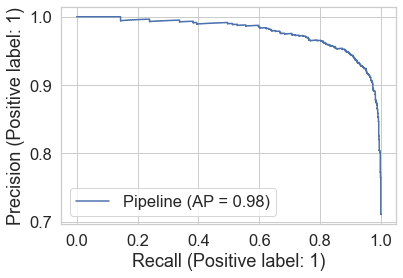

In [99]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df_split["review_union"], y=test_df_split["target_review"])

In [100]:
features_test = vectorizer.transform(test_df['review_union'])

In [101]:
y_pred = model.predict(features_test)
y_pred

array([1, 0, 1, ..., 1, 1, 1])

In [102]:
y_pred_proba = model.predict_proba(features_test)
y_pred_proba[:1]

array([[0.26993827, 0.73006173]])

In [103]:
preds = pd.DataFrame()
preds['review_id'] = test_df.index
preds['target'] = y_pred
preds.head(20)

,review_id,target
0,3,1
1,4,0
2,13,1
3,14,0
4,17,1
5,23,1
6,24,1
7,26,1
8,34,1
9,36,0


In [104]:
preds.loc[(preds['target'] == 1), 'target'] = 8
preds.head()

,review_id,target
0,3,8
1,4,0
2,13,8
3,14,0
4,17,8


In [105]:
preds['target'].value_counts()

8    33939
0    16712
Name: target, dtype: int64

In [106]:
#запись результатов в итоговый файл
preds.to_csv('eight_and_zero_only.csv', index=False)

# Первая модель, разделяющая отзывы на прощедшие и отказные построена. Теперь можно построить модели определяющие причины отказов 1 - 8

In [107]:
#сохраним все отказные отзывы в отдельный датасет, с которым и продолжим работу
train_df_negative_1 = train_df.loc[train_df['target_review'] == 1]

In [108]:
#проверим результат
train_df_negative_1.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review               1
review_union            29857
dtype: int64

**Датасет разбит**

In [109]:
test_negative_df = test_df

In [110]:
test_negative_df['target_negative'] = y_pred

In [111]:
#test_negative_df.head()

In [112]:
test_negative_df = test_negative_df.loc[test_negative_df['target_negative'] == 1 ]
test_negative_df['target_negative'].value_counts()

1    33939
Name: target_negative, dtype: int64

# Причина номер 1

Список всех значений, где в target есть 1:  
1,8      -----   1476  
1       -----     1269  
1,6        -----   141  
1,6,8     -----     48  
1,5,8     -----     33  
1,4       -----     24  
1,7----- 15  
1,3      -----       9  
1,5,6          ----- 7  
1,4,8          ----- 4  
1,4,6          ----- 3  
1,3,8      -----     3  
1,3,5    -----       2  
1,7,8        -----   2  
1,5,6,8       -----  1  
1,2,6        -----   1  
1,3,6        -----   1  

Заменим все значения 8 по этим условиям на 1

In [113]:
train_df_negative_1['target_review'] = train_df_negative_1['target']

In [114]:
train_df_negative_1.head()

,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating,target,target_review,review_union
review_id,,,,,,,,,,,,,
1,Москва,Руководитель проекта,"Расположение офиса, своего рода стабильность (госбанк)","Упростить процессы - все процессы ради процессов, а не результата. Избавиться от чрезмерного уровня бюрократии. Внедрить нормальный электронный документооборот - сейчас все на бумажках, даже то, что заводится в ЭДО. Высшему руководству избавиться от нежелания видеть проблемы - сейчас действует принцип «не вижу проблемы, значит ее нет».",хорошо,хорошо,хорошо,ужасно,ужасно,ужасно,8,8,"Москва Руководитель проекта Расположение офиса, своего рода стабильность (госбанк) Упростить процессы - все процессы ради процессов, а не результата. Избавиться от чрезмерного уровня бюрократии. Внедрить нормальный электронный документооборот - сейчас все на бумажках, даже то, что заводится в ЭДО. Высшему руководству избавиться от нежелания видеть проблемы - сейчас действует принцип «не вижу проблемы, значит ее нет». хорошо хорошо хорошо ужасно ужасно ужасно"
7,Москва,Инженер КИПиА,В принципе норм.Работать можно,Всегда есть к чему стремиться,хорошо,отлично,хорошо,плохо,отлично,плохо,8,8,Москва Инженер КИПиА В принципе норм.Работать можно Всегда есть к чему стремиться хорошо отлично хорошо плохо отлично плохо
21,Новосибирск,Менеджер по работе с крупными корпоративными и государственными клиентами (КАМ),"Ужасно , просто совдепия, зарплата нищенская","Там надо всё улучшать, место дно.",ужасно,плохо,ужасно,ужасно,ужасно,ужасно,8,8,"Новосибирск Менеджер по работе с крупными корпоративными и государственными клиентами (КАМ) Ужасно , просто совдепия, зарплата нищенская Там надо всё улучшать, место дно. ужасно плохо ужасно ужасно ужасно ужасно"
22,,Механик,Норм норм норм норм норм,Ниче ниче ниче гтчн ниче,отлично,отлично,отлично,отлично,отлично,отлично,8,8,Механик Норм норм норм норм норм Ниче ниче ниче гтчн ниче отлично отлично отлично отлично отлично отлично
31,Москва,Поиск Работы в строительстве,"Позвали на собеседование, но не сказали что нужно прежде чем устроиться оплатить обучение, не известно попадёшь работать или нет. Лохотрон",Не звать на собеседование,ужасно,ужасно,ужасно,ужасно,ужасно,ужасно,7,7,"Москва Поиск Работы в строительстве Позвали на собеседование, но не сказали что нужно прежде чем устроиться оплатить обучение, не известно попадёшь работать или нет. Лохотрон Не звать на собеседование ужасно ужасно ужасно ужасно ужасно ужасно"


In [115]:
train_df_negative_1.loc[(train_df_negative_1['target_review'] == "1,8"), 'target_review'] = 1
train_df_negative_1.loc[(train_df_negative_1['target_review'] == "1"), 'target_review'] = 1
train_df_negative_1.loc[(train_df_negative_1['target_review'] == "1,6"), 'target_review'] = 1
train_df_negative_1.loc[(train_df_negative_1['target_review'] == "1,6,8"), 'target_review'] = 1
train_df_negative_1.loc[(train_df_negative_1['target_review'] == "1,5,8"), 'target_review'] = 1
train_df_negative_1.loc[(train_df_negative_1['target_review'] == "1,4"), 'target_review'] = 1
train_df_negative_1.loc[(train_df_negative_1['target_review'] == "1,7"), 'target_review'] = 1
train_df_negative_1.loc[(train_df_negative_1['target_review'] == "1,3"), 'target_review'] = 1
train_df_negative_1.loc[(train_df_negative_1['target_review'] == "1,5,6"), 'target_review'] = 1
train_df_negative_1.loc[(train_df_negative_1['target_review'] == "1,4,8"), 'target_review'] = 1
train_df_negative_1.loc[(train_df_negative_1['target_review'] == "1,4,6"), 'target_review'] = 1
train_df_negative_1.loc[(train_df_negative_1['target_review'] == "1,3,8"), 'target_review'] = 1
train_df_negative_1.loc[(train_df_negative_1['target_review'] == "1,3,5"), 'target_review'] = 1
train_df_negative_1.loc[(train_df_negative_1['target_review'] == "1,7,8"), 'target_review'] = 1
train_df_negative_1.loc[(train_df_negative_1['target_review'] == "1,5,6,8"), 'target_review'] = 1
train_df_negative_1.loc[(train_df_negative_1['target_review'] == "1,2,6"), 'target_review'] = 1
train_df_negative_1.loc[(train_df_negative_1['target_review'] == "1,3,6"), 'target_review'] = 1

In [116]:
train_df_negative_1['target_review'].value_counts()

8        24093
1         3039
3          905
6,8        473
6          368
7          326
3,8        209
5,8        121
5          102
1,5         78
4           38
4,8         36
7,8         25
5,7         13
2           12
5,6          9
5,6,8        6
4,6          5
3,7          5
6,7          3
3,6          1
3,5,7        1
3,5,8        1
3,6,8        1
4,6,8        1
5,7,8        1
3,5          1
Name: target_review, dtype: int64

In [117]:
train_df_negative_1.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review              27
review_union            29857
dtype: int64

In [118]:
#заменим все не 1 на 8
train_df_negative_1.loc[(train_df_negative_1['target_review'] != 1), 'target_review'] = 0

In [119]:
train_df_negative_1.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review               2
review_union            29857
dtype: int64

In [120]:
train_df_negative_1['target_review'] = train_df_negative_1['target_review'].apply(int)

In [121]:
train_df_negative_1['target_review'].value_counts()

0    26834
1     3039
Name: target_review, dtype: int64

Разбиение прошло успешно, создадим модель

In [122]:
#разобьёем train_df на train и test
train_df_negative_1_split, test_df_negative_1_split = train_test_split(train_df_negative_1, test_size=2000, random_state=0)

In [123]:
test_df_negative_1_split.shape

(2000, 13)

In [124]:
test_df_negative_1_split['target_review'].value_counts()

0    1813
1     187
Name: target_review, dtype: int64

In [125]:
train_df_negative_1_split['target_review'].value_counts()

0    25021
1     2852
Name: target_review, dtype: int64

In [126]:
vectorizer_1 = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [127]:
features_1 = vectorizer_1.fit_transform(train_df_negative_1['review_union'])

In [128]:
model = LogisticRegression(random_state=0, C=10)
model.fit(features_1, train_df_negative_1['target_review'])

LogisticRegression(C=10, random_state=0)

In [129]:
model_pipeline = Pipeline([
    ("vectorizer_1", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0, C=30))
]
)

In [130]:
model_pipeline.fit(train_df_negative_1["review_union"], train_df_negative_1["target_review"])

Pipeline(steps=[('vectorizer_1',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f9b6e01fee0>)),
                ('model', LogisticRegression(C=30, random_state=0))])

In [131]:
precision_score(y_true=test_df_negative_1_split["target_review"], y_pred=model_pipeline.predict(test_df_negative_1_split["review_union"]))

0.9333333333333333

In [132]:
recall_score(y_true=test_df_negative_1_split["target_review"], y_pred=model_pipeline.predict(test_df_negative_1_split["review_union"]))

0.8235294117647058

In [133]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df_negative_1_split["target_review"], probas_pred=model_pipeline.predict_proba(test_df_negative_1_split["review_union"])[:, 1])

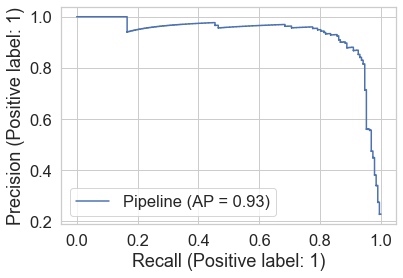

In [134]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df_negative_1_split["review_union"], y=test_df_negative_1_split["target_review"])

In [135]:
features_test_1 = vectorizer_1.transform(test_negative_df['review_union'])

In [136]:
y_pred_1 = model.predict(features_test_1)
y_pred_1

array([0, 0, 0, ..., 1, 0, 0])

In [137]:
y_pred_1_proba = model.predict_proba(features_test_1)[:,1]
y_pred_1_proba[:10]

array([9.37717972e-04, 6.65221130e-04, 1.47902624e-03, 1.04016165e-01,
       1.03958749e-04, 3.11505614e-02, 8.08675944e-01, 9.19599658e-03,
       4.82590529e-03, 3.15145779e-03])

# Причина номер 2

Список всех значений, где в target есть 2:  
2       ----      12  
1,2,6   ----       1  

Заменим все значения 8 по этим условиям на 2

In [138]:
#сохраним все отказные отзывы в отдельный датасет, с которым и продолжим работу
train_df_negative_2 = train_df.loc[train_df['target_review'] == 1]

In [139]:
#проверим результат
train_df_negative_2.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review               1
review_union            29857
dtype: int64

In [140]:
train_df_negative_2['target_review'] = train_df_negative_2['target']

In [141]:
train_df_negative_2.head()

,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating,target,target_review,review_union
review_id,,,,,,,,,,,,,
1,Москва,Руководитель проекта,"Расположение офиса, своего рода стабильность (госбанк)","Упростить процессы - все процессы ради процессов, а не результата. Избавиться от чрезмерного уровня бюрократии. Внедрить нормальный электронный документооборот - сейчас все на бумажках, даже то, что заводится в ЭДО. Высшему руководству избавиться от нежелания видеть проблемы - сейчас действует принцип «не вижу проблемы, значит ее нет».",хорошо,хорошо,хорошо,ужасно,ужасно,ужасно,8,8,"Москва Руководитель проекта Расположение офиса, своего рода стабильность (госбанк) Упростить процессы - все процессы ради процессов, а не результата. Избавиться от чрезмерного уровня бюрократии. Внедрить нормальный электронный документооборот - сейчас все на бумажках, даже то, что заводится в ЭДО. Высшему руководству избавиться от нежелания видеть проблемы - сейчас действует принцип «не вижу проблемы, значит ее нет». хорошо хорошо хорошо ужасно ужасно ужасно"
7,Москва,Инженер КИПиА,В принципе норм.Работать можно,Всегда есть к чему стремиться,хорошо,отлично,хорошо,плохо,отлично,плохо,8,8,Москва Инженер КИПиА В принципе норм.Работать можно Всегда есть к чему стремиться хорошо отлично хорошо плохо отлично плохо
21,Новосибирск,Менеджер по работе с крупными корпоративными и государственными клиентами (КАМ),"Ужасно , просто совдепия, зарплата нищенская","Там надо всё улучшать, место дно.",ужасно,плохо,ужасно,ужасно,ужасно,ужасно,8,8,"Новосибирск Менеджер по работе с крупными корпоративными и государственными клиентами (КАМ) Ужасно , просто совдепия, зарплата нищенская Там надо всё улучшать, место дно. ужасно плохо ужасно ужасно ужасно ужасно"
22,,Механик,Норм норм норм норм норм,Ниче ниче ниче гтчн ниче,отлично,отлично,отлично,отлично,отлично,отлично,8,8,Механик Норм норм норм норм норм Ниче ниче ниче гтчн ниче отлично отлично отлично отлично отлично отлично
31,Москва,Поиск Работы в строительстве,"Позвали на собеседование, но не сказали что нужно прежде чем устроиться оплатить обучение, не известно попадёшь работать или нет. Лохотрон",Не звать на собеседование,ужасно,ужасно,ужасно,ужасно,ужасно,ужасно,7,7,"Москва Поиск Работы в строительстве Позвали на собеседование, но не сказали что нужно прежде чем устроиться оплатить обучение, не известно попадёшь работать или нет. Лохотрон Не звать на собеседование ужасно ужасно ужасно ужасно ужасно ужасно"


In [142]:
train_df_negative_2.loc[(train_df_negative_2['target_review'] == "2"), 'target_review'] = 2
train_df_negative_2.loc[(train_df_negative_2['target_review'] == "1,2,6"), 'target_review'] = 2

In [143]:
train_df_negative_2['target_review'].value_counts()

8          24093
1,8         1476
1           1269
3            905
6,8          473
6            368
7            326
3,8          209
1,6          141
5,8          121
5            102
1,5           78
1,6,8         48
4             38
4,8           36
1,5,8         33
7,8           25
1,4           24
1,7           15
5,7           13
2             13
1,3            9
5,6            9
1,5,6          7
5,6,8          6
4,6            5
3,7            5
1,4,8          4
1,4,6          3
1,3,8          3
6,7            3
1,7,8          2
1,3,5          2
1,3,6          1
3,6            1
3,5,7          1
3,5,8          1
1,5,6,8        1
4,6,8          1
3,6,8          1
5,7,8          1
3,5            1
Name: target_review, dtype: int64

In [144]:
train_df_negative_2.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review              42
review_union            29857
dtype: int64

In [145]:
#заменим все не 1 на 8
train_df_negative_2.loc[(train_df_negative_2['target_review'] != 2), 'target_review'] = 8

In [146]:
train_df_negative_2.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review               2
review_union            29857
dtype: int64

In [147]:
train_df_negative_2['target_review'] = train_df_negative_2['target_review'].apply(int)

In [148]:
train_df_negative_2['target_review'].value_counts()

8    29860
2       13
Name: target_review, dtype: int64

In [149]:
#заменим все не 1 на 8
train_df_negative_2.loc[(train_df_negative_2['target_review'] == 2), 'target_review'] = 1
train_df_negative_2.loc[(train_df_negative_2['target_review'] == 8), 'target_review'] = 0

In [150]:
train_df_negative_2['target_review'].value_counts()

0    29860
1       13
Name: target_review, dtype: int64

Разбиение прошло успешно, создадим модель

In [151]:
#разобьёем train_df на train и test
train_df_negative_2_split, test_df_negative_2_split = train_test_split(train_df_negative_2, test_size=2000, random_state=2)

In [152]:
test_df_negative_2_split.shape

(2000, 13)

In [153]:
test_df_negative_2_split['target_review'].value_counts()

0    1999
1       1
Name: target_review, dtype: int64

In [154]:
train_df_negative_2_split['target_review'].value_counts()

0    27861
1       12
Name: target_review, dtype: int64

In [155]:
vectorizer_2 = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [156]:
features_2 = vectorizer_2.fit_transform(train_df_negative_2['review_union'])

In [157]:
model = LogisticRegression(random_state=0)
model.fit(features_2, train_df_negative_2['target_review'])

LogisticRegression(random_state=0)

In [158]:
model_pipeline = Pipeline([
    ("vectorizer_2", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0))
]
)

In [159]:
model_pipeline.fit(train_df_negative_2["review_union"], train_df_negative_2["target_review"])

Pipeline(steps=[('vectorizer_2',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f9b7219a9d0>)),
                ('model', LogisticRegression(random_state=0))])

In [160]:
precision_score(y_true=test_df_negative_2_split["target_review"], y_pred=model_pipeline.predict(test_df_negative_2_split["review_union"]))

0.0

In [161]:
recall_score(y_true=test_df_negative_2_split["target_review"], y_pred=model_pipeline.predict(test_df_negative_2_split["review_union"]))

0.0

In [162]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df_negative_2_split["target_review"], probas_pred=model_pipeline.predict_proba(test_df_negative_2_split["review_union"])[:, 1])

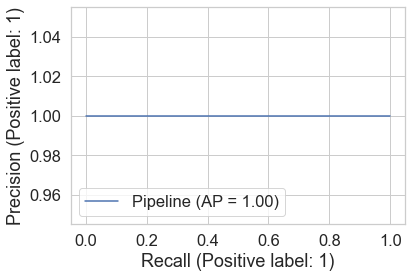

In [163]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df_negative_2_split["review_union"], y=test_df_negative_2_split["target_review"])

<span style="color:red">Построение модели по выявлению причины 2 требует больших времененных затрат и масштабирования ввиду сильного дисбаланса классов</span>

In [164]:
features_test_2 = vectorizer_2.transform(test_negative_df['review_union'])

In [165]:
y_pred_2 = model.predict(features_test_2)
y_pred_2

array([0, 0, 0, ..., 0, 0, 0])

In [166]:
y_pred_2_proba = model.predict_proba(features_test_2)[:,1]
y_pred_2_proba[:10]

array([0.00057432, 0.00051976, 0.00052427, 0.00044332, 0.0005072 ,
       0.00035972, 0.00026476, 0.00054219, 0.00051666, 0.00038817])

# Причина номер 3

Список всех значений, где в target есть 3:  
3        ----    905  
3,8       ----   209  
1,3        ----    9  
3,7        ----    5  
1,3,8      ----    3  
1,3,5       ----   2  
1,3,6      ----    1  
3,5        ----    1  
3,5,8      ----    1  
3,5,7      ----    1  
3,6,8      ----    1  
3,6        ----    1  

Заменим все значения 8 по этим условиям на 3

In [167]:
#сохраним все отказные отзывы в отдельный датасет, с которым и продолжим работу
train_df_negative_3 = train_df.loc[train_df['target_review'] == 1]

In [168]:
#проверим результат
train_df_negative_3.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review               1
review_union            29857
dtype: int64

In [169]:
train_df_negative_3['target_review'] = train_df_negative_3['target']

In [170]:
train_df_negative_3.head()

,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating,target,target_review,review_union
review_id,,,,,,,,,,,,,
1,Москва,Руководитель проекта,"Расположение офиса, своего рода стабильность (госбанк)","Упростить процессы - все процессы ради процессов, а не результата. Избавиться от чрезмерного уровня бюрократии. Внедрить нормальный электронный документооборот - сейчас все на бумажках, даже то, что заводится в ЭДО. Высшему руководству избавиться от нежелания видеть проблемы - сейчас действует принцип «не вижу проблемы, значит ее нет».",хорошо,хорошо,хорошо,ужасно,ужасно,ужасно,8,8,"Москва Руководитель проекта Расположение офиса, своего рода стабильность (госбанк) Упростить процессы - все процессы ради процессов, а не результата. Избавиться от чрезмерного уровня бюрократии. Внедрить нормальный электронный документооборот - сейчас все на бумажках, даже то, что заводится в ЭДО. Высшему руководству избавиться от нежелания видеть проблемы - сейчас действует принцип «не вижу проблемы, значит ее нет». хорошо хорошо хорошо ужасно ужасно ужасно"
7,Москва,Инженер КИПиА,В принципе норм.Работать можно,Всегда есть к чему стремиться,хорошо,отлично,хорошо,плохо,отлично,плохо,8,8,Москва Инженер КИПиА В принципе норм.Работать можно Всегда есть к чему стремиться хорошо отлично хорошо плохо отлично плохо
21,Новосибирск,Менеджер по работе с крупными корпоративными и государственными клиентами (КАМ),"Ужасно , просто совдепия, зарплата нищенская","Там надо всё улучшать, место дно.",ужасно,плохо,ужасно,ужасно,ужасно,ужасно,8,8,"Новосибирск Менеджер по работе с крупными корпоративными и государственными клиентами (КАМ) Ужасно , просто совдепия, зарплата нищенская Там надо всё улучшать, место дно. ужасно плохо ужасно ужасно ужасно ужасно"
22,,Механик,Норм норм норм норм норм,Ниче ниче ниче гтчн ниче,отлично,отлично,отлично,отлично,отлично,отлично,8,8,Механик Норм норм норм норм норм Ниче ниче ниче гтчн ниче отлично отлично отлично отлично отлично отлично
31,Москва,Поиск Работы в строительстве,"Позвали на собеседование, но не сказали что нужно прежде чем устроиться оплатить обучение, не известно попадёшь работать или нет. Лохотрон",Не звать на собеседование,ужасно,ужасно,ужасно,ужасно,ужасно,ужасно,7,7,"Москва Поиск Работы в строительстве Позвали на собеседование, но не сказали что нужно прежде чем устроиться оплатить обучение, не известно попадёшь работать или нет. Лохотрон Не звать на собеседование ужасно ужасно ужасно ужасно ужасно ужасно"


In [171]:
train_df_negative_3.loc[(train_df_negative_3['target_review'] == "3"), 'target_review'] = 3
train_df_negative_3.loc[(train_df_negative_3['target_review'] == "3,8"), 'target_review'] = 3
train_df_negative_3.loc[(train_df_negative_3['target_review'] == "1,3"), 'target_review'] = 3
train_df_negative_3.loc[(train_df_negative_3['target_review'] == "3,7"), 'target_review'] = 3
train_df_negative_3.loc[(train_df_negative_3['target_review'] == "1,3,8"), 'target_review'] = 3
train_df_negative_3.loc[(train_df_negative_3['target_review'] == "1,3,5"), 'target_review'] = 3
train_df_negative_3.loc[(train_df_negative_3['target_review'] == "1,3,6"), 'target_review'] = 3
train_df_negative_3.loc[(train_df_negative_3['target_review'] == "3,5"), 'target_review'] = 3
train_df_negative_3.loc[(train_df_negative_3['target_review'] == "3,5,8"), 'target_review'] = 3
train_df_negative_3.loc[(train_df_negative_3['target_review'] == "3,5,7"), 'target_review'] = 3
train_df_negative_3.loc[(train_df_negative_3['target_review'] == "3,6,8"), 'target_review'] = 3
train_df_negative_3.loc[(train_df_negative_3['target_review'] == "3,6"), 'target_review'] = 3

In [172]:
train_df_negative_3['target_review'].value_counts()

8          24093
1,8         1476
1           1269
3           1139
6,8          473
6            368
7            326
1,6          141
5,8          121
5            102
1,5           78
1,6,8         48
4             38
4,8           36
1,5,8         33
7,8           25
1,4           24
1,7           15
5,7           13
2             12
5,6            9
1,5,6          7
5,6,8          6
4,6            5
1,4,8          4
6,7            3
1,4,6          3
1,7,8          2
1,2,6          1
5,7,8          1
4,6,8          1
1,5,6,8        1
Name: target_review, dtype: int64

In [173]:
train_df_negative_3.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review              32
review_union            29857
dtype: int64

In [174]:
#заменим все не 3 на 8
train_df_negative_3.loc[(train_df_negative_3['target_review'] != 3), 'target_review'] = 8

In [175]:
train_df_negative_3.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review               2
review_union            29857
dtype: int64

In [176]:
train_df_negative_3['target_review'] = train_df_negative_3['target_review'].apply(int)

In [177]:
train_df_negative_3['target_review'].value_counts()

8    28734
3     1139
Name: target_review, dtype: int64

In [178]:
train_df_negative_3.loc[(train_df_negative_3['target_review'] == 3), 'target_review'] = 1
train_df_negative_3.loc[(train_df_negative_3['target_review'] == 8), 'target_review'] = 0

In [179]:
train_df_negative_3['target_review'].value_counts()

0    28734
1     1139
Name: target_review, dtype: int64

Разбиение прошло успешно, создадим модель

In [180]:
#разобьёем train_df на train и test
train_df_negative_3_split, test_df_negative_3_split = train_test_split(train_df_negative_3, test_size=2000, random_state=2)

In [181]:
test_df_negative_3_split.shape

(2000, 13)

In [182]:
test_df_negative_3_split['target_review'].value_counts()

0    1908
1      92
Name: target_review, dtype: int64

In [183]:
train_df_negative_3_split['target_review'].value_counts()

0    26826
1     1047
Name: target_review, dtype: int64

In [184]:
vectorizer_3 = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [185]:
features_3 = vectorizer_3.fit_transform(train_df_negative_3['review_union'])

In [186]:
model = LogisticRegression(random_state=0, C=10)
model.fit(features_3, train_df_negative_3['target_review'])

LogisticRegression(C=10, random_state=0)

In [187]:
model_pipeline = Pipeline([
    ("vectorizer_3", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0, C=10))
]
)

In [188]:
model_pipeline.fit(train_df_negative_3["review_union"], train_df_negative_3["target_review"])

Pipeline(steps=[('vectorizer_3',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f9b43656940>)),
                ('model', LogisticRegression(C=10, random_state=0))])

In [189]:
precision_score(y_true=test_df_negative_3_split["target_review"], y_pred=model_pipeline.predict(test_df_negative_3_split["review_union"]))

0.958904109589041

In [190]:
recall_score(y_true=test_df_negative_3_split["target_review"], y_pred=model_pipeline.predict(test_df_negative_3_split["review_union"]))

0.7608695652173914

In [191]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df_negative_3_split["target_review"], probas_pred=model_pipeline.predict_proba(test_df_negative_3_split["review_union"])[:, 1])

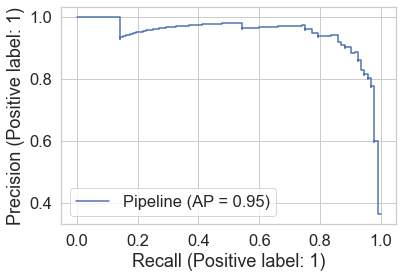

In [192]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df_negative_3_split["review_union"], y=test_df_negative_3_split["target_review"])

In [193]:
features_test_3 = vectorizer_3.transform(test_negative_df['review_union'])

In [194]:
y_pred_3 = model.predict(features_test_3)
y_pred_3

array([0, 0, 0, ..., 0, 0, 0])

In [195]:
y_pred_3_proba = model.predict_proba(features_test_3)[:,1]
y_pred_3_proba[:10]

array([0.00090277, 0.00224098, 0.01510032, 0.00968717, 0.04988545,
       0.00139323, 0.00136117, 0.00044276, 0.00812565, 0.00023753])

# Причина номер 4

Список всех значений, где в target есть 4:  
4        ----     38  
4,8       ----    36  
1,4       ----    24  
4,6       ----     5  
1,4,8      ----    4  
1,4,6      ----    3  
4,6,8      ----    1  

Заменим все значения 8 по этим условиям на 4

In [196]:
#сохраним все отказные отзывы в отдельный датасет, с которым и продолжим работу
train_df_negative_4 = train_df.loc[train_df['target_review'] == 1]

In [197]:
#проверим результат
train_df_negative_4.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review               1
review_union            29857
dtype: int64

In [198]:
train_df_negative_4['target_review'] = train_df_negative_4['target']

In [199]:
train_df_negative_4.head()

,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating,target,target_review,review_union
review_id,,,,,,,,,,,,,
1,Москва,Руководитель проекта,"Расположение офиса, своего рода стабильность (госбанк)","Упростить процессы - все процессы ради процессов, а не результата. Избавиться от чрезмерного уровня бюрократии. Внедрить нормальный электронный документооборот - сейчас все на бумажках, даже то, что заводится в ЭДО. Высшему руководству избавиться от нежелания видеть проблемы - сейчас действует принцип «не вижу проблемы, значит ее нет».",хорошо,хорошо,хорошо,ужасно,ужасно,ужасно,8,8,"Москва Руководитель проекта Расположение офиса, своего рода стабильность (госбанк) Упростить процессы - все процессы ради процессов, а не результата. Избавиться от чрезмерного уровня бюрократии. Внедрить нормальный электронный документооборот - сейчас все на бумажках, даже то, что заводится в ЭДО. Высшему руководству избавиться от нежелания видеть проблемы - сейчас действует принцип «не вижу проблемы, значит ее нет». хорошо хорошо хорошо ужасно ужасно ужасно"
7,Москва,Инженер КИПиА,В принципе норм.Работать можно,Всегда есть к чему стремиться,хорошо,отлично,хорошо,плохо,отлично,плохо,8,8,Москва Инженер КИПиА В принципе норм.Работать можно Всегда есть к чему стремиться хорошо отлично хорошо плохо отлично плохо
21,Новосибирск,Менеджер по работе с крупными корпоративными и государственными клиентами (КАМ),"Ужасно , просто совдепия, зарплата нищенская","Там надо всё улучшать, место дно.",ужасно,плохо,ужасно,ужасно,ужасно,ужасно,8,8,"Новосибирск Менеджер по работе с крупными корпоративными и государственными клиентами (КАМ) Ужасно , просто совдепия, зарплата нищенская Там надо всё улучшать, место дно. ужасно плохо ужасно ужасно ужасно ужасно"
22,,Механик,Норм норм норм норм норм,Ниче ниче ниче гтчн ниче,отлично,отлично,отлично,отлично,отлично,отлично,8,8,Механик Норм норм норм норм норм Ниче ниче ниче гтчн ниче отлично отлично отлично отлично отлично отлично
31,Москва,Поиск Работы в строительстве,"Позвали на собеседование, но не сказали что нужно прежде чем устроиться оплатить обучение, не известно попадёшь работать или нет. Лохотрон",Не звать на собеседование,ужасно,ужасно,ужасно,ужасно,ужасно,ужасно,7,7,"Москва Поиск Работы в строительстве Позвали на собеседование, но не сказали что нужно прежде чем устроиться оплатить обучение, не известно попадёшь работать или нет. Лохотрон Не звать на собеседование ужасно ужасно ужасно ужасно ужасно ужасно"


In [200]:
train_df_negative_4.loc[(train_df_negative_4['target_review'] == "4"), 'target_review'] = 4
train_df_negative_4.loc[(train_df_negative_4['target_review'] == "4,8"), 'target_review'] = 4
train_df_negative_4.loc[(train_df_negative_4['target_review'] == "1,4"), 'target_review'] = 4
train_df_negative_4.loc[(train_df_negative_4['target_review'] == "4,6"), 'target_review'] = 4
train_df_negative_4.loc[(train_df_negative_4['target_review'] == "1,4,8"), 'target_review'] = 4
train_df_negative_4.loc[(train_df_negative_4['target_review'] == "1,4,6"), 'target_review'] = 4
train_df_negative_4.loc[(train_df_negative_4['target_review'] == "4,6,8"), 'target_review'] = 4

In [201]:
train_df_negative_4['target_review'].value_counts()

8          24093
1,8         1476
1           1269
3            905
6,8          473
6            368
7            326
3,8          209
1,6          141
5,8          121
4            111
5            102
1,5           78
1,6,8         48
1,5,8         33
7,8           25
1,7           15
5,7           13
2             12
1,3            9
5,6            9
1,5,6          7
5,6,8          6
3,7            5
6,7            3
1,3,8          3
1,3,5          2
1,7,8          2
1,5,6,8        1
3,6            1
1,3,6          1
3,5,7          1
1,2,6          1
5,7,8          1
3,5,8          1
3,6,8          1
3,5            1
Name: target_review, dtype: int64

In [202]:
train_df_negative_4.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review              37
review_union            29857
dtype: int64

In [203]:
train_df_negative_4.loc[(train_df_negative_4['target_review'] != 4), 'target_review'] = 8

In [204]:
train_df_negative_4.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review               2
review_union            29857
dtype: int64

In [205]:
train_df_negative_4['target_review'] = train_df_negative_4['target_review'].apply(int)

In [206]:
train_df_negative_4['target_review'].value_counts()

8    29762
4      111
Name: target_review, dtype: int64

In [207]:
train_df_negative_4.loc[(train_df_negative_4['target_review'] == 4), 'target_review'] = 1
train_df_negative_4.loc[(train_df_negative_4['target_review'] == 8), 'target_review'] = 0

In [208]:
train_df_negative_4['target_review'].value_counts()

0    29762
1      111
Name: target_review, dtype: int64

Разбиение прошло успешно, создадим модель

In [209]:
#разобьёем train_df на train и test
train_df_negative_4_split, test_df_negative_4_split = train_test_split(train_df_negative_4, test_size=2000, random_state=2)

In [210]:
test_df_negative_4_split.shape

(2000, 13)

In [211]:
test_df_negative_4_split['target_review'].value_counts()

0    1992
1       8
Name: target_review, dtype: int64

In [212]:
train_df_negative_4_split['target_review'].value_counts()

0    27770
1      103
Name: target_review, dtype: int64

In [213]:
vectorizer_4 = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [214]:
features_4 = vectorizer_4.fit_transform(train_df_negative_4['review_union'])

In [215]:
model = LogisticRegression(random_state=0)
model.fit(features_4, train_df_negative_4['target_review'])

LogisticRegression(random_state=0)

In [216]:
model_pipeline = Pipeline([
    ("vectorizer_4", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0, C=10))
]
)

In [217]:
model_pipeline.fit(train_df_negative_4["review_union"], train_df_negative_4["target_review"])

Pipeline(steps=[('vectorizer_4',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f9b436568b0>)),
                ('model', LogisticRegression(C=10, random_state=0))])

In [218]:
precision_score(y_true=test_df_negative_4_split["target_review"], y_pred=model_pipeline.predict(test_df_negative_4_split["review_union"]))

0.0

In [219]:
recall_score(y_true=test_df_negative_4_split["target_review"], y_pred=model_pipeline.predict(test_df_negative_4_split["review_union"]))

0.0

In [220]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df_negative_4_split["target_review"], probas_pred=model_pipeline.predict_proba(test_df_negative_4_split["review_union"])[:, 1])

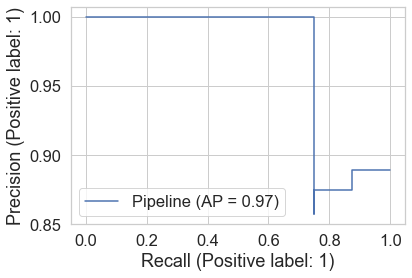

In [221]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df_negative_4_split["review_union"], y=test_df_negative_4_split["target_review"])

<span style="color:red">Построение модели по выявлению причины 4 требует больших времененных затрат и масштабирования ввиду сильного дисбаланса классов</span>

In [222]:
features_test_4 = vectorizer_4.transform(test_negative_df['review_union'])

In [223]:
y_pred_4 = model.predict(features_test_4)
y_pred_4

array([0, 0, 0, ..., 0, 0, 0])

In [224]:
y_pred_4_proba = model.predict_proba(features_test_4)[:,1]
y_pred_4_proba[:10]

array([0.00065842, 0.00107378, 0.00145532, 0.01036855, 0.00071776,
       0.00496516, 0.00130149, 0.00429525, 0.00213054, 0.00223701])

# Причина номер 5

Список всех значений, где в target есть 5:  
5,8     ----     121   
5       ----     102  
1,5       ----    78  
1,5,8     ----    33   
5,7       ----    13   
5,6       ----     9   
1,5,6      ----    7   
5,6,8      ----    6  
1,3,5       ----   2  
5,7,8       ----   1  
3,5        -----    1  
3,5,8       ----   1   
3,5,7       -----   1  
1,5,6,8     ----   1

Заменим все значения 8 по этим условиям на 5

In [225]:
#сохраним все отказные отзывы в отдельный датасет, с которым и продолжим работу
train_df_negative_5 = train_df.loc[train_df['target_review'] == 1]

In [226]:
#проверим результат
train_df_negative_5.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review               1
review_union            29857
dtype: int64

In [227]:
train_df_negative_5['target_review'] = train_df_negative_5['target']

In [228]:
train_df_negative_5.head()

,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating,target,target_review,review_union
review_id,,,,,,,,,,,,,
1,Москва,Руководитель проекта,"Расположение офиса, своего рода стабильность (госбанк)","Упростить процессы - все процессы ради процессов, а не результата. Избавиться от чрезмерного уровня бюрократии. Внедрить нормальный электронный документооборот - сейчас все на бумажках, даже то, что заводится в ЭДО. Высшему руководству избавиться от нежелания видеть проблемы - сейчас действует принцип «не вижу проблемы, значит ее нет».",хорошо,хорошо,хорошо,ужасно,ужасно,ужасно,8,8,"Москва Руководитель проекта Расположение офиса, своего рода стабильность (госбанк) Упростить процессы - все процессы ради процессов, а не результата. Избавиться от чрезмерного уровня бюрократии. Внедрить нормальный электронный документооборот - сейчас все на бумажках, даже то, что заводится в ЭДО. Высшему руководству избавиться от нежелания видеть проблемы - сейчас действует принцип «не вижу проблемы, значит ее нет». хорошо хорошо хорошо ужасно ужасно ужасно"
7,Москва,Инженер КИПиА,В принципе норм.Работать можно,Всегда есть к чему стремиться,хорошо,отлично,хорошо,плохо,отлично,плохо,8,8,Москва Инженер КИПиА В принципе норм.Работать можно Всегда есть к чему стремиться хорошо отлично хорошо плохо отлично плохо
21,Новосибирск,Менеджер по работе с крупными корпоративными и государственными клиентами (КАМ),"Ужасно , просто совдепия, зарплата нищенская","Там надо всё улучшать, место дно.",ужасно,плохо,ужасно,ужасно,ужасно,ужасно,8,8,"Новосибирск Менеджер по работе с крупными корпоративными и государственными клиентами (КАМ) Ужасно , просто совдепия, зарплата нищенская Там надо всё улучшать, место дно. ужасно плохо ужасно ужасно ужасно ужасно"
22,,Механик,Норм норм норм норм норм,Ниче ниче ниче гтчн ниче,отлично,отлично,отлично,отлично,отлично,отлично,8,8,Механик Норм норм норм норм норм Ниче ниче ниче гтчн ниче отлично отлично отлично отлично отлично отлично
31,Москва,Поиск Работы в строительстве,"Позвали на собеседование, но не сказали что нужно прежде чем устроиться оплатить обучение, не известно попадёшь работать или нет. Лохотрон",Не звать на собеседование,ужасно,ужасно,ужасно,ужасно,ужасно,ужасно,7,7,"Москва Поиск Работы в строительстве Позвали на собеседование, но не сказали что нужно прежде чем устроиться оплатить обучение, не известно попадёшь работать или нет. Лохотрон Не звать на собеседование ужасно ужасно ужасно ужасно ужасно ужасно"


In [229]:
train_df_negative_5.loc[(train_df_negative_5['target_review'] == "5,8"), 'target_review'] = 5
train_df_negative_5.loc[(train_df_negative_5['target_review'] == "5"), 'target_review'] = 5
train_df_negative_5.loc[(train_df_negative_5['target_review'] == "1,5"), 'target_review'] = 5
train_df_negative_5.loc[(train_df_negative_5['target_review'] == "1,5,8"), 'target_review'] = 5
train_df_negative_5.loc[(train_df_negative_5['target_review'] == "5,7"), 'target_review'] = 5
train_df_negative_5.loc[(train_df_negative_5['target_review'] == "5,6"), 'target_review'] = 5
train_df_negative_5.loc[(train_df_negative_5['target_review'] == "1,5,6"), 'target_review'] = 5
train_df_negative_5.loc[(train_df_negative_5['target_review'] == "5,6,8"), 'target_review'] = 5
train_df_negative_5.loc[(train_df_negative_5['target_review'] == "1,3,5"), 'target_review'] = 5
train_df_negative_5.loc[(train_df_negative_5['target_review'] == "5,7,8"), 'target_review'] = 5
train_df_negative_5.loc[(train_df_negative_5['target_review'] == "3,5"), 'target_review'] = 5
train_df_negative_5.loc[(train_df_negative_5['target_review'] == "3,5,8"), 'target_review'] = 5
train_df_negative_5.loc[(train_df_negative_5['target_review'] == "3,5,7"), 'target_review'] = 5
train_df_negative_5.loc[(train_df_negative_5['target_review'] == "1,5,6,8"), 'target_review'] = 5

In [230]:
train_df_negative_5['target_review'].value_counts()

8        24093
1,8       1476
1         1269
3          905
6,8        473
5          376
6          368
7          326
3,8        209
1,6        141
1,6,8       48
4           38
4,8         36
7,8         25
1,4         24
1,7         15
2           12
1,3          9
4,6          5
3,7          5
1,4,8        4
6,7          3
1,3,8        3
1,4,6        3
1,7,8        2
4,6,8        1
3,6,8        1
3,6          1
1,3,6        1
1,2,6        1
Name: target_review, dtype: int64

In [231]:
train_df_negative_5.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review              30
review_union            29857
dtype: int64

In [232]:
train_df_negative_5.loc[(train_df_negative_5['target_review'] != 5), 'target_review'] = 8

In [233]:
train_df_negative_5.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review               2
review_union            29857
dtype: int64

In [234]:
train_df_negative_5['target_review'] = train_df_negative_5['target_review'].apply(int)

In [235]:
train_df_negative_5['target_review'].value_counts()

8    29497
5      376
Name: target_review, dtype: int64

In [236]:
train_df_negative_5.loc[(train_df_negative_5['target_review'] == 5), 'target_review'] = 1
train_df_negative_5.loc[(train_df_negative_5['target_review'] == 8), 'target_review'] = 0

In [237]:
train_df_negative_5['target_review'].value_counts()

0    29497
1      376
Name: target_review, dtype: int64

Разбиение прошло успешно, создадим модель

In [238]:
#разобьёем train_df на train и test
train_df_negative_5_split, test_df_negative_5_split = train_test_split(train_df_negative_5, test_size=2000, random_state=2)

In [239]:
test_df_negative_5_split.shape

(2000, 13)

In [240]:
test_df_negative_5_split['target_review'].value_counts()

0    1972
1      28
Name: target_review, dtype: int64

In [241]:
train_df_negative_5_split['target_review'].value_counts()

0    27525
1      348
Name: target_review, dtype: int64

In [242]:
vectorizer_5 = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [243]:
features_5 = vectorizer_5.fit_transform(train_df_negative_5['review_union'])

In [244]:
model = LogisticRegression(random_state=0, C=12)
model.fit(features_5, train_df_negative_5['target_review'])

LogisticRegression(C=12, random_state=0)

In [245]:
model_pipeline = Pipeline([
    ("vectorizer_5", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0, C=12))
]
)

In [246]:
model_pipeline.fit(train_df_negative_5["review_union"], train_df_negative_5["target_review"])

Pipeline(steps=[('vectorizer_5',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f9b6bcd9040>)),
                ('model', LogisticRegression(C=12, random_state=0))])

In [247]:
precision_score(y_true=test_df_negative_5_split["target_review"], y_pred=model_pipeline.predict(test_df_negative_5_split["review_union"]))

1.0

In [248]:
recall_score(y_true=test_df_negative_5_split["target_review"], y_pred=model_pipeline.predict(test_df_negative_5_split["review_union"]))

0.7857142857142857

In [249]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df_negative_5_split["target_review"], probas_pred=model_pipeline.predict_proba(test_df_negative_5_split["review_union"])[:, 1])

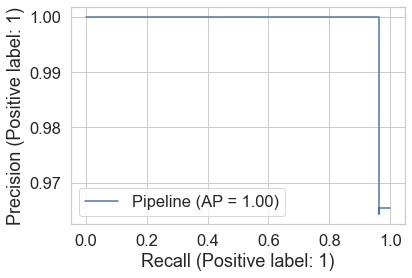

In [250]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df_negative_5_split["review_union"], y=test_df_negative_5_split["target_review"])

In [251]:
features_test_5 = vectorizer_5.transform(test_negative_df['review_union'])

In [252]:
y_pred_5 = model.predict(features_test_5)
y_pred_5

array([0, 0, 0, ..., 0, 0, 0])

In [253]:
y_pred_5_proba = model.predict_proba(features_test_5)[:,1]
y_pred_5_proba[:10]

array([4.35085004e-05, 1.03752601e-04, 5.72300953e-04, 3.12476947e-02,
       2.04405268e-04, 8.59045736e-03, 2.05171577e-04, 2.53410641e-03,
       3.04034474e-03, 1.80245824e-04])

# Причина номер 6

Список всех значений, где в target есть 6:  
6,8      ----    473   
6       ----     368   
1,6      ----    141   
1,6,8     ----    48   
5,6       ----     9   
1,5,6      ----    7   
5,6,8      ----    6   
4,6        ----    5   
6,7        ----    3  
1,4,6       ----   3  
1,3,6      ----    1  
1,2,6      ----    1  
4,6,8       ----   1   
1,5,6,8     ----   1  
3,6,8       ----   1  
3,6         ----   1  

Заменим все значения 8 по этим условиям на 6

In [254]:
#сохраним все отказные отзывы в отдельный датасет, с которым и продолжим работу
train_df_negative_6 = train_df.loc[train_df['target_review'] == 1]

In [255]:
#проверим результат
train_df_negative_6.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review               1
review_union            29857
dtype: int64

In [256]:
train_df_negative_6['target_review'] = train_df_negative_6['target']

In [257]:
train_df_negative_6.head()

,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating,target,target_review,review_union
review_id,,,,,,,,,,,,,
1,Москва,Руководитель проекта,"Расположение офиса, своего рода стабильность (госбанк)","Упростить процессы - все процессы ради процессов, а не результата. Избавиться от чрезмерного уровня бюрократии. Внедрить нормальный электронный документооборот - сейчас все на бумажках, даже то, что заводится в ЭДО. Высшему руководству избавиться от нежелания видеть проблемы - сейчас действует принцип «не вижу проблемы, значит ее нет».",хорошо,хорошо,хорошо,ужасно,ужасно,ужасно,8,8,"Москва Руководитель проекта Расположение офиса, своего рода стабильность (госбанк) Упростить процессы - все процессы ради процессов, а не результата. Избавиться от чрезмерного уровня бюрократии. Внедрить нормальный электронный документооборот - сейчас все на бумажках, даже то, что заводится в ЭДО. Высшему руководству избавиться от нежелания видеть проблемы - сейчас действует принцип «не вижу проблемы, значит ее нет». хорошо хорошо хорошо ужасно ужасно ужасно"
7,Москва,Инженер КИПиА,В принципе норм.Работать можно,Всегда есть к чему стремиться,хорошо,отлично,хорошо,плохо,отлично,плохо,8,8,Москва Инженер КИПиА В принципе норм.Работать можно Всегда есть к чему стремиться хорошо отлично хорошо плохо отлично плохо
21,Новосибирск,Менеджер по работе с крупными корпоративными и государственными клиентами (КАМ),"Ужасно , просто совдепия, зарплата нищенская","Там надо всё улучшать, место дно.",ужасно,плохо,ужасно,ужасно,ужасно,ужасно,8,8,"Новосибирск Менеджер по работе с крупными корпоративными и государственными клиентами (КАМ) Ужасно , просто совдепия, зарплата нищенская Там надо всё улучшать, место дно. ужасно плохо ужасно ужасно ужасно ужасно"
22,,Механик,Норм норм норм норм норм,Ниче ниче ниче гтчн ниче,отлично,отлично,отлично,отлично,отлично,отлично,8,8,Механик Норм норм норм норм норм Ниче ниче ниче гтчн ниче отлично отлично отлично отлично отлично отлично
31,Москва,Поиск Работы в строительстве,"Позвали на собеседование, но не сказали что нужно прежде чем устроиться оплатить обучение, не известно попадёшь работать или нет. Лохотрон",Не звать на собеседование,ужасно,ужасно,ужасно,ужасно,ужасно,ужасно,7,7,"Москва Поиск Работы в строительстве Позвали на собеседование, но не сказали что нужно прежде чем устроиться оплатить обучение, не известно попадёшь работать или нет. Лохотрон Не звать на собеседование ужасно ужасно ужасно ужасно ужасно ужасно"


In [258]:
train_df_negative_6.loc[(train_df_negative_6['target_review'] == "6,8"), 'target_review'] = 6
train_df_negative_6.loc[(train_df_negative_6['target_review'] == "6"), 'target_review'] = 6
train_df_negative_6.loc[(train_df_negative_6['target_review'] == "1,6"), 'target_review'] = 6
train_df_negative_6.loc[(train_df_negative_6['target_review'] == "1,6,8"), 'target_review'] = 6
train_df_negative_6.loc[(train_df_negative_6['target_review'] == "5,6"), 'target_review'] = 6
train_df_negative_6.loc[(train_df_negative_6['target_review'] == "1,5,6"), 'target_review'] = 6
train_df_negative_6.loc[(train_df_negative_6['target_review'] == "4,6"), 'target_review'] = 6
train_df_negative_6.loc[(train_df_negative_6['target_review'] == "6,7"), 'target_review'] = 6
train_df_negative_6.loc[(train_df_negative_6['target_review'] == "1,4,6"), 'target_review'] = 6
train_df_negative_6.loc[(train_df_negative_6['target_review'] == "1,3,6"), 'target_review'] = 6
train_df_negative_6.loc[(train_df_negative_6['target_review'] == "1,2,6"), 'target_review'] = 6
train_df_negative_6.loc[(train_df_negative_6['target_review'] == "4,6,8"), 'target_review'] = 6
train_df_negative_6.loc[(train_df_negative_6['target_review'] == "1,5,6,8"), 'target_review'] = 6
train_df_negative_6.loc[(train_df_negative_6['target_review'] == "3,6,8"), 'target_review'] = 6
train_df_negative_6.loc[(train_df_negative_6['target_review'] == "3,6"), 'target_review'] = 6

In [259]:
train_df_negative_6['target_review'].value_counts()

8        24093
1,8       1476
1         1269
6         1063
3          905
7          326
3,8        209
5,8        121
5          102
1,5         78
4           38
4,8         36
1,5,8       33
7,8         25
1,4         24
1,7         15
5,7         13
2           12
1,3          9
5,6,8        6
3,7          5
1,4,8        4
1,3,8        3
1,7,8        2
1,3,5        2
3,5,7        1
5,7,8        1
3,5,8        1
3,5          1
Name: target_review, dtype: int64

In [260]:
train_df_negative_6.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review              29
review_union            29857
dtype: int64

In [261]:
train_df_negative_6.loc[(train_df_negative_6['target_review'] != 6), 'target_review'] = 8

In [262]:
train_df_negative_6.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review               2
review_union            29857
dtype: int64

In [263]:
train_df_negative_6['target_review'] = train_df_negative_6['target_review'].apply(int)

In [264]:
train_df_negative_6['target_review'].value_counts()

8    28810
6     1063
Name: target_review, dtype: int64

In [265]:
train_df_negative_6.loc[(train_df_negative_6['target_review'] == 6), 'target_review'] = 1
train_df_negative_6.loc[(train_df_negative_6['target_review'] == 8), 'target_review'] = 0

In [266]:
train_df_negative_6['target_review'].value_counts()

0    28810
1     1063
Name: target_review, dtype: int64

Разбиение прошло успешно, создадим модель

In [267]:
#разобьёем train_df на train и test
train_df_negative_6_split, test_df_negative_6_split = train_test_split(train_df_negative_6, test_size=2000, random_state=2)

In [268]:
test_df_negative_6_split.shape

(2000, 13)

In [269]:
test_df_negative_6_split['target_review'].value_counts()

0    1930
1      70
Name: target_review, dtype: int64

In [270]:
train_df_negative_6_split['target_review'].value_counts()

0    26880
1      993
Name: target_review, dtype: int64

In [271]:
vectorizer_6 = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [272]:
features_6 = vectorizer_6.fit_transform(train_df_negative_6['review_union'])

In [273]:
model = LogisticRegression(random_state=0, C=15)
model.fit(features_6, train_df_negative_6['target_review'])

LogisticRegression(C=15, random_state=0)

In [274]:
model_pipeline = Pipeline([
    ("vectorizer_6", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0, C=15))
]
)

In [275]:
model_pipeline.fit(train_df_negative_6["review_union"], train_df_negative_6["target_review"])

Pipeline(steps=[('vectorizer_6',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f9b486ef1f0>)),
                ('model', LogisticRegression(C=15, random_state=0))])

In [276]:
precision_score(y_true=test_df_negative_6_split["target_review"], y_pred=model_pipeline.predict(test_df_negative_6_split["review_union"]))

0.9473684210526315

In [277]:
recall_score(y_true=test_df_negative_6_split["target_review"], y_pred=model_pipeline.predict(test_df_negative_6_split["review_union"]))

0.7714285714285715

In [278]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df_negative_6_split["target_review"], probas_pred=model_pipeline.predict_proba(test_df_negative_6_split["review_union"])[:, 1])

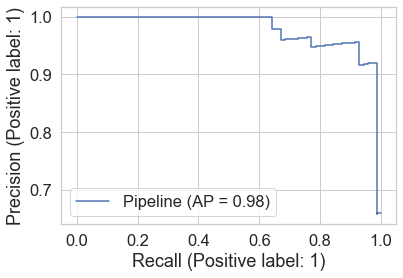

In [279]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df_negative_6_split["review_union"], y=test_df_negative_6_split["target_review"])

In [280]:
features_test_6 = vectorizer_6.transform(test_negative_df['review_union'])

In [281]:
y_pred_6 = model.predict(features_test_6)
y_pred_6

array([0, 0, 0, ..., 0, 0, 0])

In [282]:
y_pred_6_proba = model.predict_proba(features_test_6)[:,1]
y_pred_6_proba[:10]

array([2.02180255e-04, 5.19885215e-04, 1.78361828e-04, 1.80135852e-03,
       5.97173958e-05, 8.24423262e-03, 9.61956260e-06, 7.26734908e-03,
       7.75843094e-03, 5.50443281e-03])

# Причина номер 7

Список всех значений, где в target есть 7:  
7         ----   326   
7,8      ----     25   
1,7          ----- 15   
5,7     ----      13   
3,7       ----     5   
6,7          ----  3   
1,7,8       ----   2   
5,7,8       ----   1  
3,5,7      ----    1   

Заменим все значения 8 по этим условиям на 7

In [283]:
#сохраним все отказные отзывы в отдельный датасет, с которым и продолжим работу
train_df_negative_7 = train_df.loc[train_df['target_review'] == 1]

In [284]:
#проверим результат
train_df_negative_7.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review               1
review_union            29857
dtype: int64

In [285]:
train_df_negative_7['target_review'] = train_df_negative_7['target']

In [286]:
train_df_negative_7.head()

,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating,target,target_review,review_union
review_id,,,,,,,,,,,,,
1,Москва,Руководитель проекта,"Расположение офиса, своего рода стабильность (госбанк)","Упростить процессы - все процессы ради процессов, а не результата. Избавиться от чрезмерного уровня бюрократии. Внедрить нормальный электронный документооборот - сейчас все на бумажках, даже то, что заводится в ЭДО. Высшему руководству избавиться от нежелания видеть проблемы - сейчас действует принцип «не вижу проблемы, значит ее нет».",хорошо,хорошо,хорошо,ужасно,ужасно,ужасно,8,8,"Москва Руководитель проекта Расположение офиса, своего рода стабильность (госбанк) Упростить процессы - все процессы ради процессов, а не результата. Избавиться от чрезмерного уровня бюрократии. Внедрить нормальный электронный документооборот - сейчас все на бумажках, даже то, что заводится в ЭДО. Высшему руководству избавиться от нежелания видеть проблемы - сейчас действует принцип «не вижу проблемы, значит ее нет». хорошо хорошо хорошо ужасно ужасно ужасно"
7,Москва,Инженер КИПиА,В принципе норм.Работать можно,Всегда есть к чему стремиться,хорошо,отлично,хорошо,плохо,отлично,плохо,8,8,Москва Инженер КИПиА В принципе норм.Работать можно Всегда есть к чему стремиться хорошо отлично хорошо плохо отлично плохо
21,Новосибирск,Менеджер по работе с крупными корпоративными и государственными клиентами (КАМ),"Ужасно , просто совдепия, зарплата нищенская","Там надо всё улучшать, место дно.",ужасно,плохо,ужасно,ужасно,ужасно,ужасно,8,8,"Новосибирск Менеджер по работе с крупными корпоративными и государственными клиентами (КАМ) Ужасно , просто совдепия, зарплата нищенская Там надо всё улучшать, место дно. ужасно плохо ужасно ужасно ужасно ужасно"
22,,Механик,Норм норм норм норм норм,Ниче ниче ниче гтчн ниче,отлично,отлично,отлично,отлично,отлично,отлично,8,8,Механик Норм норм норм норм норм Ниче ниче ниче гтчн ниче отлично отлично отлично отлично отлично отлично
31,Москва,Поиск Работы в строительстве,"Позвали на собеседование, но не сказали что нужно прежде чем устроиться оплатить обучение, не известно попадёшь работать или нет. Лохотрон",Не звать на собеседование,ужасно,ужасно,ужасно,ужасно,ужасно,ужасно,7,7,"Москва Поиск Работы в строительстве Позвали на собеседование, но не сказали что нужно прежде чем устроиться оплатить обучение, не известно попадёшь работать или нет. Лохотрон Не звать на собеседование ужасно ужасно ужасно ужасно ужасно ужасно"


In [287]:
train_df_negative_7.loc[(train_df_negative_7['target_review'] == "7"), 'target_review'] = 7
train_df_negative_7.loc[(train_df_negative_7['target_review'] == "7,8"), 'target_review'] = 7
train_df_negative_7.loc[(train_df_negative_7['target_review'] == "1,7"), 'target_review'] = 7
train_df_negative_7.loc[(train_df_negative_7['target_review'] == "5,7"), 'target_review'] = 7
train_df_negative_7.loc[(train_df_negative_7['target_review'] == "3,7"), 'target_review'] = 7
train_df_negative_7.loc[(train_df_negative_7['target_review'] == "6,7"), 'target_review'] = 7
train_df_negative_7.loc[(train_df_negative_7['target_review'] == "1,7,8"), 'target_review'] = 7
train_df_negative_7.loc[(train_df_negative_7['target_review'] == "5,7,8"), 'target_review'] = 7
train_df_negative_7.loc[(train_df_negative_7['target_review'] == "3,5,7"), 'target_review'] = 7

In [288]:
train_df_negative_7['target_review'].value_counts()

8          24093
1,8         1476
1           1269
3            905
6,8          473
7            391
6            368
3,8          209
1,6          141
5,8          121
5            102
1,5           78
1,6,8         48
4             38
4,8           36
1,5,8         33
1,4           24
2             12
5,6            9
1,3            9
1,5,6          7
5,6,8          6
4,6            5
1,4,8          4
1,3,8          3
1,4,6          3
1,3,5          2
3,6            1
1,3,6          1
1,5,6,8        1
1,2,6          1
4,6,8          1
3,6,8          1
3,5,8          1
3,5            1
Name: target_review, dtype: int64

In [289]:
train_df_negative_7.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review              35
review_union            29857
dtype: int64

In [290]:
train_df_negative_7.loc[(train_df_negative_7['target_review'] != 7), 'target_review'] = 8

In [291]:
train_df_negative_7.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review               2
review_union            29857
dtype: int64

In [292]:
train_df_negative_7['target_review'] = train_df_negative_7['target_review'].apply(int)

In [293]:
train_df_negative_7['target_review'].value_counts()

8    29482
7      391
Name: target_review, dtype: int64

In [294]:
train_df_negative_7.loc[(train_df_negative_7['target_review'] == 7), 'target_review'] = 1
train_df_negative_7.loc[(train_df_negative_7['target_review'] == 8), 'target_review'] = 0

In [295]:
train_df_negative_7['target_review'].value_counts()

0    29482
1      391
Name: target_review, dtype: int64

Разбиение прошло успешно, создадим модель

In [296]:
#разобьёем train_df на train и test
train_df_negative_7_split, test_df_negative_7_split = train_test_split(train_df_negative_7, test_size=2000, random_state=2)

In [297]:
test_df_negative_7_split.shape

(2000, 13)

In [298]:
test_df_negative_7_split['target_review'].value_counts()

0    1967
1      33
Name: target_review, dtype: int64

In [299]:
train_df_negative_7_split['target_review'].value_counts()

0    27515
1      358
Name: target_review, dtype: int64

In [300]:
vectorizer_7 = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [301]:
features_7 = vectorizer_7.fit_transform(train_df_negative_7['review_union'])

In [302]:
model = LogisticRegression(random_state=0, C=30)
model.fit(features_7, train_df_negative_7['target_review'])

LogisticRegression(C=30, random_state=0)

In [303]:
model_pipeline = Pipeline([
    ("vectorizer_7", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0, C=20))
]
)

In [304]:
model_pipeline.fit(train_df_negative_7["review_union"], train_df_negative_7["target_review"])

Pipeline(steps=[('vectorizer_7',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f9b4cf6e1f0>)),
                ('model', LogisticRegression(C=20, random_state=0))])

In [305]:
precision_score(y_true=test_df_negative_7_split["target_review"], y_pred=model_pipeline.predict(test_df_negative_7_split["review_union"]))

1.0

In [306]:
recall_score(y_true=test_df_negative_7_split["target_review"], y_pred=model_pipeline.predict(test_df_negative_7_split["review_union"]))

0.7878787878787878

In [307]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df_negative_7_split["target_review"], probas_pred=model_pipeline.predict_proba(test_df_negative_7_split["review_union"])[:, 1])

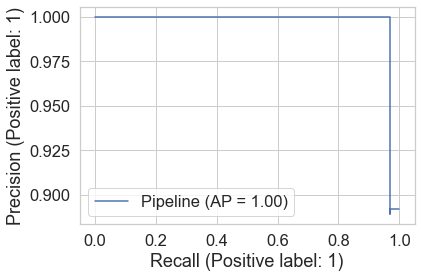

In [308]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df_negative_7_split["review_union"], y=test_df_negative_7_split["target_review"])

In [309]:
features_test_7 = vectorizer_7.transform(test_negative_df['review_union'])

In [310]:
y_pred_7 = model.predict(features_test_7)
y_pred_7

array([0, 0, 0, ..., 0, 0, 0])

In [311]:
y_pred_7_proba = model.predict_proba(features_test_7)[:,1]
y_pred_7_proba[:10]

array([9.80375100e-05, 2.93346110e-03, 7.53601758e-04, 2.70694684e-03,
       2.57193965e-04, 7.81633789e-05, 2.01297268e-05, 1.59526173e-04,
       5.17806870e-05, 3.49565025e-04])

# Причина номер 8

Список всех значений, где в target есть 8:  
8       ----   24093  
1,8      ----   1476  
6,8       ----   473  
3,8       ----   209  
5,8       ----   121  
1,6,8      ----   48  
4,8        ----   36  
1,5,8      ----   33  
7,8        ----   25  
5,6,8      ----    6  
1,4,8     ----     4  
1,3,8     ----     3  
1,7,8     ----     2  
5,7,8     ----     1  
3,5,8     ----     1  
4,6,8     ----     1  
1,5,6,8    ----    1  
3,6,8      ----    1

Заменим все значения 8 по этим условиям на 8

In [312]:
#сохраним все отказные отзывы в отдельный датасет, с которым и продолжим работу
train_df_negative_8 = train_df.loc[train_df['target_review'] == 1]

In [313]:
#проверим результат
train_df_negative_8.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review               1
review_union            29857
dtype: int64

In [314]:
train_df_negative_8['target_review'] = train_df_negative_8['target']

In [315]:
train_df_negative_8.head()

,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating,target,target_review,review_union
review_id,,,,,,,,,,,,,
1,Москва,Руководитель проекта,"Расположение офиса, своего рода стабильность (госбанк)","Упростить процессы - все процессы ради процессов, а не результата. Избавиться от чрезмерного уровня бюрократии. Внедрить нормальный электронный документооборот - сейчас все на бумажках, даже то, что заводится в ЭДО. Высшему руководству избавиться от нежелания видеть проблемы - сейчас действует принцип «не вижу проблемы, значит ее нет».",хорошо,хорошо,хорошо,ужасно,ужасно,ужасно,8,8,"Москва Руководитель проекта Расположение офиса, своего рода стабильность (госбанк) Упростить процессы - все процессы ради процессов, а не результата. Избавиться от чрезмерного уровня бюрократии. Внедрить нормальный электронный документооборот - сейчас все на бумажках, даже то, что заводится в ЭДО. Высшему руководству избавиться от нежелания видеть проблемы - сейчас действует принцип «не вижу проблемы, значит ее нет». хорошо хорошо хорошо ужасно ужасно ужасно"
7,Москва,Инженер КИПиА,В принципе норм.Работать можно,Всегда есть к чему стремиться,хорошо,отлично,хорошо,плохо,отлично,плохо,8,8,Москва Инженер КИПиА В принципе норм.Работать можно Всегда есть к чему стремиться хорошо отлично хорошо плохо отлично плохо
21,Новосибирск,Менеджер по работе с крупными корпоративными и государственными клиентами (КАМ),"Ужасно , просто совдепия, зарплата нищенская","Там надо всё улучшать, место дно.",ужасно,плохо,ужасно,ужасно,ужасно,ужасно,8,8,"Новосибирск Менеджер по работе с крупными корпоративными и государственными клиентами (КАМ) Ужасно , просто совдепия, зарплата нищенская Там надо всё улучшать, место дно. ужасно плохо ужасно ужасно ужасно ужасно"
22,,Механик,Норм норм норм норм норм,Ниче ниче ниче гтчн ниче,отлично,отлично,отлично,отлично,отлично,отлично,8,8,Механик Норм норм норм норм норм Ниче ниче ниче гтчн ниче отлично отлично отлично отлично отлично отлично
31,Москва,Поиск Работы в строительстве,"Позвали на собеседование, но не сказали что нужно прежде чем устроиться оплатить обучение, не известно попадёшь работать или нет. Лохотрон",Не звать на собеседование,ужасно,ужасно,ужасно,ужасно,ужасно,ужасно,7,7,"Москва Поиск Работы в строительстве Позвали на собеседование, но не сказали что нужно прежде чем устроиться оплатить обучение, не известно попадёшь работать или нет. Лохотрон Не звать на собеседование ужасно ужасно ужасно ужасно ужасно ужасно"


In [316]:
train_df_negative_8.loc[(train_df_negative_8['target_review'] == "8"), 'target_review'] = 8
train_df_negative_8.loc[(train_df_negative_8['target_review'] == "1,8"), 'target_review'] = 8
train_df_negative_8.loc[(train_df_negative_8['target_review'] == "6,8"), 'target_review'] = 8
train_df_negative_8.loc[(train_df_negative_8['target_review'] == "3,8"), 'target_review'] = 8
train_df_negative_8.loc[(train_df_negative_8['target_review'] == "5,8"), 'target_review'] = 8
train_df_negative_8.loc[(train_df_negative_8['target_review'] == "1,6,8"), 'target_review'] = 8
train_df_negative_8.loc[(train_df_negative_8['target_review'] == "4,8"), 'target_review'] = 8
train_df_negative_8.loc[(train_df_negative_8['target_review'] == "1,5,8"), 'target_review'] = 8
train_df_negative_8.loc[(train_df_negative_8['target_review'] == "7,8"), 'target_review'] = 8
train_df_negative_8.loc[(train_df_negative_8['target_review'] == "5,6,8"), 'target_review'] = 8
train_df_negative_8.loc[(train_df_negative_8['target_review'] == "1,4,8"), 'target_review'] = 8
train_df_negative_8.loc[(train_df_negative_8['target_review'] == "1,3,8"), 'target_review'] = 8
train_df_negative_8.loc[(train_df_negative_8['target_review'] == "1,7,8"), 'target_review'] = 8
train_df_negative_8.loc[(train_df_negative_8['target_review'] == "5,7,8"), 'target_review'] = 8
train_df_negative_8.loc[(train_df_negative_8['target_review'] == "3,5,8"), 'target_review'] = 8
train_df_negative_8.loc[(train_df_negative_8['target_review'] == "4,6,8"), 'target_review'] = 8
train_df_negative_8.loc[(train_df_negative_8['target_review'] == "1,5,6,8"), 'target_review'] = 8
train_df_negative_8.loc[(train_df_negative_8['target_review'] == "3,6,8"), 'target_review'] = 8

In [317]:
train_df_negative_8['target_review'].value_counts()

8        26534
1         1269
3          905
6          368
7          326
1,6        141
5          102
1,5         78
4           38
1,4         24
1,7         15
5,7         13
2           12
5,6          9
1,3          9
1,5,6        7
4,6          5
3,7          5
1,4,6        3
6,7          3
1,3,5        2
1,3,6        1
3,6          1
3,5,7        1
1,2,6        1
3,5          1
Name: target_review, dtype: int64

In [318]:
train_df_negative_8.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review              26
review_union            29857
dtype: int64

In [319]:
train_df_negative_8.loc[(train_df_negative_8['target_review'] != 8), 'target_review'] = 0

In [320]:
train_df_negative_8.nunique()

city                      715
position                10628
positive                26376
negative                26789
salary_rating               5
team_rating                 5
managment_rating            5
career_rating               5
workplace_rating            5
rest_recovery_rating        5
target                     43
target_review               2
review_union            29857
dtype: int64

In [321]:
train_df_negative_8['target_review'] = train_df_negative_8['target_review'].apply(int)

In [322]:
train_df_negative_8['target_review'].value_counts()

8    26534
0     3339
Name: target_review, dtype: int64

In [323]:
train_df_negative_8.loc[(train_df_negative_8['target_review'] == 8), 'target_review'] = 1
train_df_negative_8.loc[(train_df_negative_8['target_review'] == 0), 'target_review'] = 0

In [324]:
train_df_negative_8['target_review'].value_counts()

1    26534
0     3339
Name: target_review, dtype: int64

Разбиение прошло успешно, создадим модель

In [325]:
#разобьёем train_df на train и test
train_df_negative_8_split, test_df_negative_8_split = train_test_split(train_df_negative_8, test_size=2000, random_state=2)

In [326]:
test_df_negative_8_split.shape

(2000, 13)

In [327]:
test_df_negative_8_split['target_review'].value_counts()

1    1768
0     232
Name: target_review, dtype: int64

In [328]:
train_df_negative_8_split['target_review'].value_counts()

1    24766
0     3107
Name: target_review, dtype: int64

In [329]:
vectorizer_8 = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [330]:
features_8 = vectorizer_8.fit_transform(train_df_negative_8['review_union'])

In [331]:
model = LogisticRegression(random_state=0, C=10)
model.fit(features_8, train_df_negative_8['target_review'])

LogisticRegression(C=10, random_state=0)

In [332]:
model_pipeline = Pipeline([
    ("vectorizer_8", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0, C=10))
]
)

In [333]:
model_pipeline.fit(train_df_negative_8["review_union"], train_df_negative_8["target_review"])

Pipeline(steps=[('vectorizer_8',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f9b4c7110d0>)),
                ('model', LogisticRegression(C=10, random_state=0))])

In [334]:
precision_score(y_true=test_df_negative_8_split["target_review"], y_pred=model_pipeline.predict(test_df_negative_8_split["review_union"]))

0.9560737527114967

In [335]:
recall_score(y_true=test_df_negative_8_split["target_review"], y_pred=model_pipeline.predict(test_df_negative_8_split["review_union"]))

0.9971719457013575

In [336]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df_negative_8_split["target_review"], probas_pred=model_pipeline.predict_proba(test_df_negative_8_split["review_union"])[:, 1])

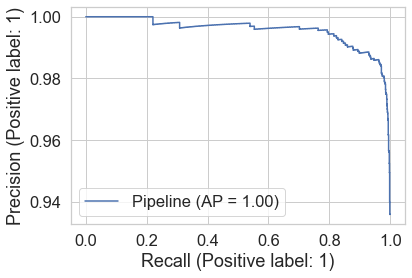

In [337]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df_negative_8_split["review_union"], y=test_df_negative_8_split["target_review"])

In [338]:
features_test_8 = vectorizer_8.transform(test_negative_df['review_union'])

In [339]:
y_pred_8 = model.predict(features_test_8)
y_pred_8

array([1, 1, 1, ..., 1, 1, 1])

In [340]:
y_pred_8_proba = model.predict_proba(features_test_8)[:,1]
y_pred_8_proba[:10]

array([0.99190505, 0.99137026, 0.99640807, 0.79457626, 0.99904976,
       0.8818088 , 0.67992145, 0.98301042, 0.96675366, 0.99781109])

# Построим таблицу общей вероятности по классам

In [341]:
full_predict_table = pd.DataFrame()
full_predict_table['review_id'] = test_negative_df.index
full_predict_table['predict_class_1'] = y_pred_1_proba
full_predict_table['predict_class_2'] = y_pred_2_proba
full_predict_table['predict_class_3'] = y_pred_3_proba
full_predict_table['predict_class_4'] = y_pred_4_proba
full_predict_table['predict_class_5'] = y_pred_5_proba
full_predict_table['predict_class_6'] = y_pred_6_proba
full_predict_table['predict_class_7'] = y_pred_7_proba
full_predict_table['predict_class_8'] = y_pred_8_proba
full_predict_table.head(20)

,review_id,predict_class_1,predict_class_2,predict_class_3,predict_class_4,predict_class_5,predict_class_6,predict_class_7,predict_class_8
0,3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.99
1,13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.99
2,17,0.00,0.00,0.02,0.00,0.00,0.00,0.00,1.00
3,23,0.10,0.00,0.01,0.01,0.03,0.00,0.00,0.79
4,24,0.00,0.00,0.05,0.00,0.00,0.00,0.00,1.00
5,26,0.03,0.00,0.00,0.00,0.01,0.01,0.00,0.88
6,34,0.81,0.00,0.00,0.00,0.00,0.00,0.00,0.68
7,50,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.98
8,52,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.97
9,61,0.00,0.00,0.00,0.00,0.00,0.01,0.00,1.00


In [342]:
full_predict_table.to_csv('full_predict_table.csv', index=False)

In [343]:
FULL_PREDICTION_TABLE = 'full_predict_table.csv'
EIGHT_AND_ZERO = 'eight_and_zero_only.csv'

In [344]:
eight_and_zero_only = pd.read_csv(EIGHT_AND_ZERO, index_col = 'review_id')
eight_and_zero_only.head()

,target
review_id,
3,8
4,0
13,8
14,0
17,8


In [345]:
full_predict_table = pd.read_csv(FULL_PREDICTION_TABLE, index_col = 'review_id')
full_predict_table.head(20)

,predict_class_1,predict_class_2,predict_class_3,predict_class_4,predict_class_5,predict_class_6,predict_class_7,predict_class_8
review_id,,,,,,,,
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.99
13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.99
17,0.00,0.00,0.02,0.00,0.00,0.00,0.00,1.00
23,0.10,0.00,0.01,0.01,0.03,0.00,0.00,0.79
24,0.00,0.00,0.05,0.00,0.00,0.00,0.00,1.00
26,0.03,0.00,0.00,0.00,0.01,0.01,0.00,0.88
34,0.81,0.00,0.00,0.00,0.00,0.00,0.00,0.68
50,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.98
52,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.97


# Общая таблица вероятностей причин готова, напишем условие

In [346]:
full_predict_table.describe()

,predict_class_1,predict_class_2,predict_class_3,predict_class_4,predict_class_5,predict_class_6,predict_class_7,predict_class_8
count,"33,939.00","33,939.00","33,939.00","33,939.00","33,939.00","33,939.00","33,939.00","33,939.00"
mean,0.08,0.00,0.03,0.00,0.01,0.03,0.01,0.91
std,0.17,0.00,0.10,0.00,0.03,0.09,0.05,0.15
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.91
50%,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.97
75%,0.06,0.00,0.01,0.00,0.00,0.01,0.00,0.99
max,1.00,0.00,0.99,0.11,0.99,1.00,1.00,1.00


Классы 2 и 4 определены с крайне низкой вероятностью

In [347]:
full_predict_table.head(10)

,predict_class_1,predict_class_2,predict_class_3,predict_class_4,predict_class_5,predict_class_6,predict_class_7,predict_class_8
review_id,,,,,,,,
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.99
13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.99
17,0.00,0.00,0.02,0.00,0.00,0.00,0.00,1.00
23,0.10,0.00,0.01,0.01,0.03,0.00,0.00,0.79
24,0.00,0.00,0.05,0.00,0.00,0.00,0.00,1.00
26,0.03,0.00,0.00,0.00,0.01,0.01,0.00,0.88
34,0.81,0.00,0.00,0.00,0.00,0.00,0.00,0.68
50,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.98
52,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.97


In [348]:
full_predict_table['predict_class_1'] = (full_predict_table['predict_class_1'] > 0.5).astype(int)
full_predict_table['predict_class_2'] = (full_predict_table['predict_class_2'] > 0.5).astype(int)
full_predict_table['predict_class_3'] = (full_predict_table['predict_class_3'] > 0.5).astype(int)
full_predict_table['predict_class_4'] = (full_predict_table['predict_class_4'] > 0.5).astype(int)
full_predict_table['predict_class_5'] = (full_predict_table['predict_class_5'] > 0.5).astype(int)
full_predict_table['predict_class_6'] = (full_predict_table['predict_class_6'] > 0.5).astype(int)
full_predict_table['predict_class_7'] = (full_predict_table['predict_class_7'] > 0.5).astype(int)
full_predict_table['predict_class_8'] = (full_predict_table['predict_class_8'] > 0.5).astype(int)

In [349]:
full_predict_table.head(10)

,predict_class_1,predict_class_2,predict_class_3,predict_class_4,predict_class_5,predict_class_6,predict_class_7,predict_class_8
review_id,,,,,,,,
3,0,0,0,0,0,0,0,1
13,0,0,0,0,0,0,0,1
17,0,0,0,0,0,0,0,1
23,0,0,0,0,0,0,0,1
24,0,0,0,0,0,0,0,1
26,0,0,0,0,0,0,0,1
34,1,0,0,0,0,0,0,1
50,0,0,0,0,0,0,0,1
52,0,0,0,0,0,0,0,1


In [350]:
full_predict_table.loc[(full_predict_table['predict_class_1'] == 0), 'predict_class_1'] = " "
full_predict_table.loc[(full_predict_table['predict_class_1'] == 1), 'predict_class_1'] = "1"
full_predict_table.loc[(full_predict_table['predict_class_2'] == 0), 'predict_class_2'] = " "
full_predict_table.loc[(full_predict_table['predict_class_2'] == 1), 'predict_class_2'] = "2"
full_predict_table.loc[(full_predict_table['predict_class_3'] == 0), 'predict_class_3'] = " "
full_predict_table.loc[(full_predict_table['predict_class_3'] == 1), 'predict_class_3'] = "3"
full_predict_table.loc[(full_predict_table['predict_class_4'] == 0), 'predict_class_4'] = " "
full_predict_table.loc[(full_predict_table['predict_class_4'] == 1), 'predict_class_4'] = "4"
full_predict_table.loc[(full_predict_table['predict_class_5'] == 0), 'predict_class_5'] = " "
full_predict_table.loc[(full_predict_table['predict_class_5'] == 1), 'predict_class_5'] = "5"
full_predict_table.loc[(full_predict_table['predict_class_6'] == 0), 'predict_class_6'] = " "
full_predict_table.loc[(full_predict_table['predict_class_6'] == 1), 'predict_class_6'] = "6"
full_predict_table.loc[(full_predict_table['predict_class_7'] == 0), 'predict_class_7'] = " "
full_predict_table.loc[(full_predict_table['predict_class_7'] == 1), 'predict_class_7'] = "7"
full_predict_table.loc[(full_predict_table['predict_class_8'] == 0), 'predict_class_8'] = " "
full_predict_table.loc[(full_predict_table['predict_class_8'] == 1), 'predict_class_8'] = "8"

In [351]:
full_predict_table.head(10)

,predict_class_1,predict_class_2,predict_class_3,predict_class_4,predict_class_5,predict_class_6,predict_class_7,predict_class_8
review_id,,,,,,,,
3,,,,,,,,8
13,,,,,,,,8
17,,,,,,,,8
23,,,,,,,,8
24,,,,,,,,8
26,,,,,,,,8
34,1,,,,,,,8
50,,,,,,,,8
52,,,,,,,,8


In [352]:
full_predict_table['target'] = full_predict_table['predict_class_1'] + ',' + full_predict_table['predict_class_2'] + ',' + full_predict_table['predict_class_3'] + ',' + full_predict_table['predict_class_4'] + ',' + full_predict_table['predict_class_5'] + ',' + full_predict_table['predict_class_6'] + ',' + full_predict_table['predict_class_7'] + ',' + full_predict_table['predict_class_8']

In [353]:
full_predict_table['target'].value_counts()

 , , , , , , ,8    30968
1, , , , , , ,8     1147
1, , , , , , ,       386
 , , , , , , ,       383
 , ,3, , , , ,       276
 , , , , ,6, ,8      275
 , ,3, , , , ,8      196
 , , , , , ,7,        87
 , , , , ,6, ,        67
1, , , , ,6, ,        48
 , , , , , ,7,8       41
1, , , , ,6, ,8       28
 , , , ,5, , ,8       12
1, , , ,5, , ,         9
 , , , ,5, , ,         9
1, , , , , ,7,         3
1, , , ,5, , ,8        1
1, , , , ,6,7,         1
1, ,3, , , , ,         1
 , , , ,5, ,7,         1
Name: target, dtype: int64

In [354]:
full_predict_table.loc[(full_predict_table['target'] == " , , , , , , ,8"), 'target'] = '8'
full_predict_table.loc[(full_predict_table['target'] == "1, , , , , , ,8"), 'target'] = '1,8'
full_predict_table.loc[(full_predict_table['target'] == "1, , , , , , , "), 'target'] = '1'
full_predict_table.loc[(full_predict_table['target'] == " , , , , , , , "), 'target'] = '8'
full_predict_table.loc[(full_predict_table['target'] == " , ,3, , , , , "), 'target'] = '3'
full_predict_table.loc[(full_predict_table['target'] == " , , , , ,6, ,8"), 'target'] = '6,8'
full_predict_table.loc[(full_predict_table['target'] == " , ,3, , , , ,8"), 'target'] = '3,8'
full_predict_table.loc[(full_predict_table['target'] == " , , , , , ,7, "), 'target'] = '7'
full_predict_table.loc[(full_predict_table['target'] == " , , , , ,6, , "), 'target'] = '6'
full_predict_table.loc[(full_predict_table['target'] == "1, , , , ,6, , "), 'target'] = '1,6'
full_predict_table.loc[(full_predict_table['target'] == " , , , , , ,7,8"), 'target'] = '7,8'
full_predict_table.loc[(full_predict_table['target'] == "1, , , , ,6, ,8"), 'target'] = '1,6,8'
full_predict_table.loc[(full_predict_table['target'] == " , , , ,5, , ,8"), 'target'] = '1,5,8'
full_predict_table.loc[(full_predict_table['target'] == " , , , ,5, , , "), 'target'] = '5'
full_predict_table.loc[(full_predict_table['target'] == "1, , , ,5, , , "), 'target'] = '1,5'
full_predict_table.loc[(full_predict_table['target'] == "1, , , , , ,7, "), 'target'] = '1,7'
full_predict_table.loc[(full_predict_table['target'] == "1, , , , ,6,7, "), 'target'] = '1,6,7'
full_predict_table.loc[(full_predict_table['target'] == "1, , , ,5, , ,8"), 'target'] = '1,5,8'
full_predict_table.loc[(full_predict_table['target'] == " , , , ,5, ,7, "), 'target'] = '1,5,7'
full_predict_table.loc[(full_predict_table['target'] == "1, ,3, , , , , "), 'target'] = '1,3'

In [355]:
full_predict_table['target'].value_counts()

8        31351
1,8       1147
1          386
3          276
6,8        275
3,8        196
7           87
6           67
1,6         48
7,8         41
1,6,8       28
1,5,8       13
5            9
1,5          9
1,7          3
1,6,7        1
1,3          1
1,5,7        1
Name: target, dtype: int64

In [356]:
full_predict_table.head()

,predict_class_1,predict_class_2,predict_class_3,predict_class_4,predict_class_5,predict_class_6,predict_class_7,predict_class_8,target
review_id,,,,,,,,,
3,,,,,,,,8,8
13,,,,,,,,8,8
17,,,,,,,,8,8
23,,,,,,,,8,8
24,,,,,,,,8,8


In [357]:
eight_and_zero_only.head()

,target
review_id,
3,8
4,0
13,8
14,0
17,8


In [358]:
final_predict_table = pd.DataFrame()
final_predict_table['review_id'] = eight_and_zero_only.index
final_predict_table['target'] = 1
final_predict_table.head(20)

,review_id,target
0,3,1
1,4,1
2,13,1
3,14,1
4,17,1
5,23,1
6,24,1
7,26,1
8,34,1
9,36,1


In [359]:
final_predict_table.index = list(final_predict_table["review_id"])
final_predict_table.head(20)

,review_id,target
3,3,1
4,4,1
13,13,1
14,14,1
17,17,1
23,23,1
24,24,1
26,26,1
34,34,1
36,36,1


In [360]:
final_predict_table['target'] = eight_and_zero_only['target']
final_predict_table['target'] = full_predict_table['target']
final_predict_table.loc[final_predict_table['target'].isna(), 'target'] = "0"

In [361]:
final_predict_table.head(20)

,review_id,target
3,3,8
4,4,0
13,13,8
14,14,0
17,17,8
23,23,8
24,24,8
26,26,8
34,34,"1,8"
36,36,0


In [362]:
final_predict_table['target'].value_counts()

8        31351
0        16712
1,8       1147
1          386
3          276
6,8        275
3,8        196
7           87
6           67
1,6         48
7,8         41
1,6,8       28
1,5,8       13
1,5          9
5            9
1,7          3
1,5,7        1
1,6,7        1
1,3          1
Name: target, dtype: int64

In [363]:
final_predict_table.to_csv('final_predict_table_SUPERFINAL.csv', index=False)